In [1]:
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

In [2]:
print("----------------Reading the Data-------------------------")
PATH = os.getcwd()
os.chdir('Alphabets/')

X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)

np.random.shuffle(X_train.to_numpy()) #Randomly shuffle the training data for batching

train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

print("----------------Data Reading completed-------------------")

os.chdir('../')

print("----------------Preprocessing the data-------------------")
X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples

#Separating 15% of the training Data as Validation Dataset
X_valid = X_train.iloc[(int(0.85*m)):]
valid_class = train_class[(int(0.85*m)):]
X_train = X_train.iloc[0:int(0.85*m)]
train_class = train_class[0:int(0.85*m)]


m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features

print("The total number of training samples = {}".format(m))
print("The total number of validation samples = {}".format(X_valid.shape[0]))
print("The number of features = {}".format(n))

----------------Reading the Data-------------------------
----------------Data Reading completed-------------------
----------------Preprocessing the data-------------------
The total number of training samples = 11050
The total number of validation samples = 1950
The number of features = 784


In [3]:
#To get the one hot encoding of each label
print("--------Perform 1-hot encoding of class labels------------")

train_class_enc = pd.get_dummies(train_class).to_numpy()
valid_class_enc = pd.get_dummies(valid_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()
print("--------------------Done----------------------------------")

--------Perform 1-hot encoding of class labels------------
--------------------Done----------------------------------


In [4]:
#Add the intercept term to the data samples both in training and test dataset
print("--------Adding the intercept term in the dataset as bias------------")
X_train = np.hstack((np.ones((m,1)),X_train.to_numpy()))
X_valid = np.hstack((np.ones((X_valid.shape[0],1)), X_valid.to_numpy()))
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test.to_numpy()))
print("-----------------------------Done----------------------------------")

--------Adding the intercept term in the dataset as bias------------
-----------------------------Done----------------------------------


In [5]:
#Mini-Batch formation

batch_size = 5 # Mini-Batch Size

print("----------------Forming mini-batches of size {}---------------------".format(batch_size))
mini_batch = [(X_train[i:i+batch_size,:], train_class_enc[i:i+batch_size]) for i in range(0, m, batch_size)]
print("The number of mini-batches formed is = {}".format(len(mini_batch)))

----------------Forming mini-batches of size 5---------------------
The number of mini-batches formed is = 2210


In [6]:
#Theta Initialization 

def theta_init(n, r, arch=[50], mode='normal'):
    theta = []
    for i in range(len(arch)+1):
        if i == 0:
            dim0=n+1
            dim1=arch[i]
        elif (i == len(arch)):
            dim0=arch[i-1]+1
            dim1 = r
        else:
            dim0=arch[i-1]+1
            dim1= arch[i]
        if (mode=='normal'):
            theta.append(np.random.normal(0,0.05, (dim0,dim1)))
        elif(mode=='random'):
            theta.append(2*np.random.random((dim0, dim1))-1)
        elif(mode=='uniform'):
            theta.append(np.random.uniform(-0.05,0.05, (dim0,dim1)))
            
        #theta.append(np.zeros((dim0, dim1)))
    return theta

In [7]:
# Sigmoid activation function
def activation(x):
    return 1/(1+np.exp(-x))

#ReLU Activation Function
def relu_act(x):
    return np.maximum(0.0, x)

#Derivative of ReLU activation Function
def deriv_relu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def softplus(x):
    return np.log(1+np.exp(x))

def deriv_softplus(x):
    return 1/(1+np.exp(-x))

In [8]:
# Forward propagation

def forward_prop(data, theta, act_fn='sigmoid'):
    fm = []
    fm.append(data)
    #Sigmoid Activation Function 
    if (act_fn == 'sigmoid'):
        for l in range(len(theta)):
            fm.append(activation(np.dot(fm[l], theta[l])))
            if (l!=len(theta)-1):
                fm[l+1]=np.hstack((np.ones((fm[l+1].shape[0],1)),fm[l+1])) #Add intercept term as bias for each layer
    #ReLU Activation Function 
    elif(act_fn == 'relu'):
        for l in range(len(theta)):
            if (l != len(theta)-1):
                fm.append(relu_act(np.dot(fm[l], theta[l])))
                fm[l+1]=np.hstack((np.ones((fm[l+1].shape[0],1)),fm[l+1])) #Add intercept term as bias for each layer
            else:
                fm.append(activation(np.dot(fm[l], theta[l])))
    #Softplus Activation Function       
    elif(act_fn == 'softplus'):
        for l in range(len(theta)):
            if (l != len(theta)-1):
                fm.append(softplus(np.dot(fm[l], theta[l])))
                fm[l+1]=np.hstack((np.ones((fm[l+1].shape[0],1)),fm[l+1])) #Add intercept term as bias for each layer
            else:
                fm.append(activation(np.dot(fm[l], theta[l])))
    return fm

In [9]:
# Backward propagation
def backward_prop(fm, Y_b, theta, batch_size, act_fn='sigmoid', cost_fn='sqr_error'):
    delta = [None]*len(fm)
    for l in range(len(fm)-1, 0, -1):
        if (l == len(fm)-1):
            if (cost_fn=='entropy'):
                delta[l] = ((1/batch_size)*((Y_b/fm[l])-((1-Y_b)/(1-fm[l])))*fm[l]*(1-fm[l])) #Entropy Loss
            else:
                delta[l] = ((1/batch_size)*(Y_b - fm[l])*fm[l]*(1-fm[l])) #MSE
        elif (l+1 == len(fm)-1):
            if (act_fn == 'sigmoid'):
                delta[l]=(np.dot(delta[l+1], theta[l].T)*fm[l]*(1-fm[l]))
            elif(act_fn == 'relu'):
                delta[l]=np.dot(delta[l+1], theta[l].T)*deriv_relu(fm[l])
            elif(act_fn=='softplus'):
                delta[l]=np.dot(delta[l+1], theta[l].T)*deriv_softplus(fm[l])
        else:
            if (act_fn == 'sigmoid'):
                delta[l]=(np.dot(delta[l+1][:,1:], theta[l].T)*fm[l]*(1-fm[l])) #To remove delta corresponding to bias node
            elif(act_fn == 'relu'):
                delta[l]=np.dot(delta[l+1][:,1:], theta[l].T)*deriv_relu(fm[l])
            elif(act_fn=='softplus'):
                delta[l]=np.dot(delta[l+1][:,1:], theta[l].T)*deriv_softplus(fm[l])
    return delta

In [10]:
#Cost Function 
def cost_total(X, theta, Y, m, act_fn='sigmoid', cost_fn='sqr_error'):
    fm = forward_prop(X, theta, act_fn)
    if (cost_fn == 'sqr_error'):
        cost = (1/(2*m))*np.sum((Y-fm[-1])**2) #MSE
    else:
        cost = -(1/m)*(np.sum(((Y*np.log(fm[-1]))+((1-Y)*(np.log(1-fm[-1])))))) #Cross Entropy
    return cost

In [11]:
def calc_accuracy(data, theta, actual_class, act_fn='sigmoid'):
    pred_class = forward_prop(data, theta, act_fn)
    test_pred_class = pred_class[-1]
    for i in range(len(test_pred_class)):
        test_pred_class[i][test_pred_class[i] == np.max(test_pred_class[i])] = 1 #Choose one with max probability
        test_pred_class[i][test_pred_class[i] != np.max(test_pred_class[i])] = 0


    test_acc = 0
    for i in range(len(actual_class)):
        if (np.array_equal(test_pred_class[i], actual_class[i])):
            test_acc+=1
    test_acc /= data.shape[0]

    return (test_acc*100)

## PART AB - One Hidden Layer Neural Network

In [12]:
def training(mini_batch, X_valid, valid_class_enc, theta, lr, act_fn='sigmoid', lr_mode='constant', cost_fn='sqr_error'):
    lr0=lr
    epoch = 1 # Number of epochs
    early_stop=0 #Early stop count of iteration
    
    cost_init = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0], act_fn, cost_fn)
    
    while(True):
        count_batch = 0
        print("Initial Cost on Val dataset for this epoch {} = {}".format(epoch, cost_init))
        
        if(lr_mode == "adaptive"):
            lr = lr0/(np.power(epoch, 1/4))
            print("learning rate for this epoch = ", lr)
        
        for b in mini_batch:
            X_b = b[0] 
            Y_b = b[1]
            
            #Forward Propagation
            fm = forward_prop(X_b, theta, act_fn)
            
            if (count_batch % 60 == 0):
                print("Error on this batch = "+str(cost_total(X_b, theta, Y_b, batch_size, act_fn, cost_fn)))
                    
            #Backward Propagation
            delta = [None]*len(fm)
            delta = backward_prop(fm, Y_b, theta, batch_size, act_fn, cost_fn)

            #Theta Update
            for t in range(len(theta)):
                if (t == len(theta)-1):
                    theta[t] += lr*np.dot(fm[t].T, delta[t+1]) 
                else:
                    theta[t] += lr*np.dot(fm[t].T, delta[t+1])[:,1:]
            print("Delta shape = ", delta[1].shape, delta[2].shape)
            print("theta shape = ", theta[0].shape, theta[1].shape)
            count_batch+=1
            break
        epoch+=1 #Number of epochs
                
        cost_final = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0], act_fn, cost_fn)
        print("Cost on val dataset after {} epochs is = {}".format(epoch, cost_final))
        
        #Stopping criteria for sigmoid - when Validation loss stops decreasing beyond a threshold for 10 epochs
        if (act_fn =='sigmoid'):
            if (abs(cost_final-cost_init) < 1e-05):
                early_stop +=1
            else:
                early_stop=0
            if (early_stop == 10):
                print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
                break
        
        #Stopping criteria for relu - when Validation loss increases continuously for 10 epochs
        elif(act_fn=='relu' or act_fn=='softplus'):
            if ((cost_final-cost_init) > 0):
                early_stop +=1
            else:
                early_stop=0
            if (early_stop == 10):
                print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
                break
        
        cost_init = cost_final
        break
        
    return epoch, theta

In [13]:
def plot_accuracy(arch_test, train_accuracy, test_accuracy, valid_accuracy):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title("Accuracy with number of hidden units \n in one hidden layer network")
    ax.plot(arch_test, train_accuracy, marker='o', label='Train Accuracy')
    ax.plot(arch_test, valid_accuracy, marker='o',label='Validation Accuracy')
    ax.plot(arch_test, test_accuracy, marker='o', label='Test Accuracy')
    ax.set_xlabel("number of hidden units")
    ax.set_ylabel("Accuracy (%)")

    plt.legend()
    #plt.savefig("plots/partc/accuracy_normal_lr0.5_cube.png", dpi=1000, bbox_inches='tight')
    plt.show()

In [14]:
def plot_epoch(arch_test, epochs, train_time):
    fig = plt.figure()
    ax = fig.add_subplot(211)
    plt.title("Epochs/Time with number of hidden units \n in one hidden layer network")
    ax.plot(arch_test, epochs, c='b', marker='o', label='#epochs')
    ax.set_xlabel("number of hidden units")
    ax.set_ylabel("Epochs")
    ax.legend()

    ax1 = fig.add_subplot(212)
    ax1.plot(arch_test, train_time, c='b', marker='o', label='train time')
    ax1.set_xlabel("number of hidden units")
    ax1.set_ylabel("train time(sec)")
    plt.legend()
    #plt.savefig("plots/partc/epochs_time_normal_lr0.5_cube.png", dpi=1000, bbox_inches='tight')
    plt.show()

In [15]:
arch_test = [1,5,10,50,100] # Specifically for part a and b
#arch = [50] #means one hidden layer with 50 perceptrons (DEFAULT)
r = np.max(train_class) + 1 # Default value of the number of classes = 26

In [16]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

lr=0.5

for i in range(len(arch_test)):
    #Choose between normal or random. Normal gives better results
    theta = theta_init(n, r, [arch_test[i]], 'normal')
    #print(theta[0].shape, theta[1].shape, theta[2].shape)
    print("Training the network with {} hidden layer with {} units".format(len([arch_test[i]]), arch_test[i]))
    print("The parameters of the layers are of the shape:")

    for j in range(len(theta)):
        print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))

    start = time.time()
    epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'sigmoid')
    
    epochs.append(epoch)
    train_time.append(time.time()-start)
    train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
    valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
    test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
    print("\n------------------------------------------------------------------------------")
    print("The stats for number of units in the hidden layer = {} are as below:".format(arch_test[i]))
    print("------------------------------------------------------------------------------")
    print("The number of epochs = {}".format(epochs[-1]))
    print("The training time = {:2.3f}sec".format(train_time[-1]))
    print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
    print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
    print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
    print("------------------------------------------------------------------------------\n")

Training the network with 1 hidden layer with 1 units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 1)
theta between layer 1 and layer 2 is (2, 26)
Initial Cost on Val dataset for this epoch 1 = 3.2366244790899774
Error on this batch = 3.234730100306655


IndexError: list index out of range

------------------Plotting Graphs for Part B - Fixed LR - One Hidden Layer ------------------


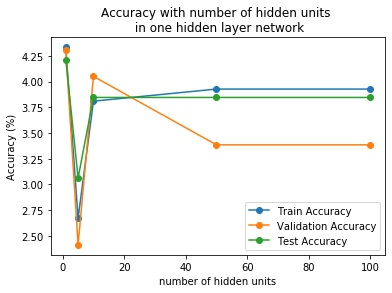

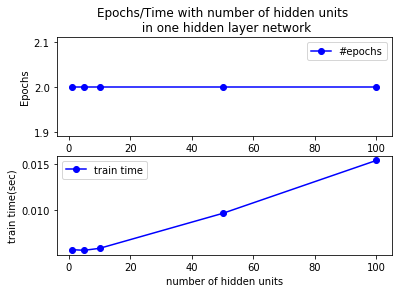

In [44]:
print("------------------Plotting Graphs for Part B - Fixed LR - One Hidden Layer ------------------")
plot_accuracy(arch_test, train_accuracy, test_accuracy, valid_accuracy)
plot_epoch(arch_test, epochs, train_time)

## Part C - Adaptive Learning rate

In [90]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

lr0=0.5

for i in range(len(arch_test)):
    theta = theta_init(n, r, [arch_test[i]], 'normal')
    #print(theta[0].shape, theta[1].shape, theta[2].shape)
    print("Training the network with {} hidden layer with {} units".format(len([arch_test[i]]), arch_test[i]))
    print("The parameters of the layers are of the shape:")

    for j in range(len(theta)):
        print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))

    start = time.time()
    epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr0, 'sigmoid', 'adaptive')
    epochs.append(epoch)
    train_time.append(time.time()-start)
    train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
    valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
    test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
    print("\n------------------------------------------------------------------------------")
    print("The stats for number of units in the hidden layer = {} are as below:".format(arch_test[i]))
    print("------------------------------------------------------------------------------")
    print("The number of epochs = {}".format(epochs[-1]))
    print("The training time = {:2.3f}sec".format(train_time[-1]))
    print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
    print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
    print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
    print("------------------------------------------------------------------------------\n")

Training the network with 1 hidden layer with 1 units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 1)
theta between layer 1 and layer 2 is (2, 26)
Initial Cost on Val dataset for this epoch 1 = 3.2597392406061334
learning rate for this epoch =  0.5
Error on this batch = 3.258361740537336
Error on this batch = 0.5819904510458613
Cost on val dataset after 2 epochs is = 0.5204024792332181
Initial Cost on Val dataset for this epoch 2 = 0.5204024792332181
learning rate for this epoch =  0.4204482076268573
Error on this batch = 0.5202182476249874
Error on this batch = 0.50212506489877
Cost on val dataset after 3 epochs is = 0.4949624359871587
Initial Cost on Val dataset for this epoch 3 = 0.4949624359871587
learning rate for this epoch =  0.37991784282579627
Error on this batch = 0.4948485111676423
Error on this batch = 0.49057920223495843
Cost on val dataset after 4 epochs is = 0.48822364573631355
Initial Cost on Val dataset for this epoch 4 = 0.

Error on this batch = 0.4808622057072821
Cost on val dataset after 33 epochs is = 0.48087237888632844
Initial Cost on Val dataset for this epoch 33 = 0.48087237888632844
learning rate for this epoch =  0.2086130724305753
Error on this batch = 0.4807808160964955
Error on this batch = 0.48086017546199744
Cost on val dataset after 34 epochs is = 0.4808706260663819
cost initial= 0.48087237888632844 , cost final=0.4808706260663819 , change in cost= -1.7528199465211003e-06

------------------------------------------------------------------------------
The stats for number of units in the hidden layer = 1 are as below:
------------------------------------------------------------------------------
The number of epochs = 34
The training time = 2.163sec
The training accuracy is = 3.973%
The validation accuracy is = 3.128%
The test accuracy is = 3.846%
------------------------------------------------------------------------------

Training the network with 1 hidden layer with 5 units
The paramete

Cost on val dataset after 10 epochs is = 0.4810343673084456
Initial Cost on Val dataset for this epoch 10 = 0.4810343673084456
learning rate for this epoch =  0.28117066259517454
Error on this batch = 0.480916481605657
Error on this batch = 0.4810017030440847
Cost on val dataset after 11 epochs is = 0.48103106224571907
Initial Cost on Val dataset for this epoch 11 = 0.48103106224571907
learning rate for this epoch =  0.2745502433880562
Error on this batch = 0.4809136069741128
Error on this batch = 0.4809987635196389
Cost on val dataset after 12 epochs is = 0.4810278525830765
Initial Cost on Val dataset for this epoch 12 = 0.4810278525830765
learning rate for this epoch =  0.2686424829558855
Error on this batch = 0.48091077379551955
Error on this batch = 0.48099593164119336
Cost on val dataset after 13 epochs is = 0.48102472781311595
Initial Cost on Val dataset for this epoch 13 = 0.48102472781311595
learning rate for this epoch =  0.2633201939239633
Error on this batch = 0.480908005228

Cost on val dataset after 25 epochs is = 0.4308390192203968
Initial Cost on Val dataset for this epoch 25 = 0.4308390192203968
learning rate for this epoch =  0.22360679774997896
Error on this batch = 0.42463729820746243
Error on this batch = 0.43832162491402576
Cost on val dataset after 26 epochs is = 0.42504557291164574
Initial Cost on Val dataset for this epoch 26 = 0.42504557291164574
learning rate for this epoch =  0.2214250071345737
Error on this batch = 0.41948296891911485
Error on this batch = 0.4336120664941014
Cost on val dataset after 27 epochs is = 0.4189259015501969
Initial Cost on Val dataset for this epoch 27 = 0.4189259015501969
learning rate for this epoch =  0.21934566882541542
Error on this batch = 0.41410075649129957
Error on this batch = 0.42855988913067267
Cost on val dataset after 28 epochs is = 0.4124580820502143
Initial Cost on Val dataset for this epoch 28 = 0.4124580820502143
learning rate for this epoch =  0.2173604359724957
Error on this batch = 0.408435798

Cost on val dataset after 57 epochs is = 0.2562703223868598
Initial Cost on Val dataset for this epoch 57 = 0.2562703223868598
learning rate for this epoch =  0.18197062654897384
Error on this batch = 0.2428650682544209
Error on this batch = 0.27654060452233153
Cost on val dataset after 58 epochs is = 0.2525415173157063
Initial Cost on Val dataset for this epoch 58 = 0.2525415173157063
learning rate for this epoch =  0.1811811475152165
Error on this batch = 0.23872119841991782
Error on this batch = 0.27266112603794185
Cost on val dataset after 59 epochs is = 0.2489207258471806
Initial Cost on Val dataset for this epoch 59 = 0.2489207258471806
learning rate for this epoch =  0.180408502419387
Error on this batch = 0.2347148121852778
Error on this batch = 0.26889180438382276
Cost on val dataset after 60 epochs is = 0.24540982945864656
Initial Cost on Val dataset for this epoch 60 = 0.24540982945864656
learning rate for this epoch =  0.17965205598154213
Error on this batch = 0.23084700392

Cost on val dataset after 89 epochs is = 0.1831008907469176
Initial Cost on Val dataset for this epoch 89 = 0.1831008907469176
learning rate for this epoch =  0.1627880431731981
Error on this batch = 0.1644590177224032
Error on this batch = 0.2008744100484762
Cost on val dataset after 90 epochs is = 0.18188549568929502
Initial Cost on Val dataset for this epoch 90 = 0.18188549568929502
learning rate for this epoch =  0.16233395773754944
Error on this batch = 0.16315414164117506
Error on this batch = 0.1995765502755002
Cost on val dataset after 91 epochs is = 0.1807070258318478
Initial Cost on Val dataset for this epoch 91 = 0.1807070258318478
learning rate for this epoch =  0.16188613565728216
Error on this batch = 0.16188387568468293
Error on this batch = 0.19831198845053932
Cost on val dataset after 92 epochs is = 0.17956378002748996
Initial Cost on Val dataset for this epoch 92 = 0.17956378002748996
learning rate for this epoch =  0.161444423121811
Error on this batch = 0.1606464828

Cost on val dataset after 121 epochs is = 0.15658371575880936
Initial Cost on Val dataset for this epoch 121 = 0.15658371575880936
learning rate for this epoch =  0.15075567228888181
Error on this batch = 0.13432914694187997
Error on this batch = 0.1705011639787388
Cost on val dataset after 122 epochs is = 0.15602454311382913
Initial Cost on Val dataset for this epoch 122 = 0.15602454311382913
learning rate for this epoch =  0.1504457925986288
Error on this batch = 0.1336504856619447
Error on this batch = 0.16980403490986434
Cost on val dataset after 123 epochs is = 0.15547578358610503
Initial Cost on Val dataset for this epoch 123 = 0.15547578358610503
learning rate for this epoch =  0.15013907175244492
Error on this batch = 0.1329827714069663
Error on this batch = 0.1691174903823866
Cost on val dataset after 124 epochs is = 0.15493711334642557
Initial Cost on Val dataset for this epoch 124 = 0.15493711334642557
learning rate for this epoch =  0.1498354522579582
Error on this batch = 

Cost on val dataset after 153 epochs is = 0.14263616015465203
Initial Cost on Val dataset for this epoch 153 = 0.14263616015465203
learning rate for this epoch =  0.14216645907653844
Error on this batch = 0.11695068325294208
Error on this batch = 0.15239431229385045
Cost on val dataset after 154 epochs is = 0.14229928697511143
Initial Cost on Val dataset for this epoch 154 = 0.14229928697511143
learning rate for this epoch =  0.14193510524403224
Error on this batch = 0.11652096840040599
Error on this batch = 0.15193837226931325
Cost on val dataset after 155 epochs is = 0.14196688471090552
Initial Cost on Val dataset for this epoch 155 = 0.14196688471090552
learning rate for this epoch =  0.1417056217041599
Error on this batch = 0.11609651586111898
Error on this batch = 0.1514875822197722
Cost on val dataset after 156 epochs is = 0.14163885543878865
Initial Cost on Val dataset for this epoch 156 = 0.14163885543878865
learning rate for this epoch =  0.14147798141631754
Error on this batc

Error on this batch = 0.14027295197966397
Cost on val dataset after 185 epochs is = 0.13367554832510678
Initial Cost on Val dataset for this epoch 185 = 0.13367554832510678
learning rate for this epoch =  0.13557420681068058
Error on this batch = 0.10532269542455634
Error on this batch = 0.13993959276136345
Cost on val dataset after 186 epochs is = 0.13344459927646046
Initial Cost on Val dataset for this epoch 186 = 0.13344459927646046
learning rate for this epoch =  0.13539161487207826
Error on this batch = 0.10501548645225192
Error on this batch = 0.13960920449656003
Cost on val dataset after 187 epochs is = 0.13321603341666818
Initial Cost on Val dataset for this epoch 187 = 0.13321603341666818
learning rate for this epoch =  0.13521024592529318
Error on this batch = 0.10471092568850063
Error on this batch = 0.13928174038886554
Cost on val dataset after 188 epochs is = 0.13298980946887634
Initial Cost on Val dataset for this epoch 188 = 0.13298980946887634
learning rate for this epo

Error on this batch = 0.13087731597018853
Cost on val dataset after 217 epochs is = 0.12729242013742334
Initial Cost on Val dataset for this epoch 217 = 0.12729242013742334
learning rate for this epoch =  0.13027319690770342
Error on this batch = 0.09659119070192762
Error on this batch = 0.13061983861746781
Cost on val dataset after 218 epochs is = 0.1271212140397166
Initial Cost on Val dataset for this epoch 218 = 0.1271212140397166
learning rate for this epoch =  0.13012354336154894
Error on this batch = 0.09634874872276009
Error on this batch = 0.13036421126760067
Cost on val dataset after 219 epochs is = 0.12695143906570966
Initial Cost on Val dataset for this epoch 219 = 0.12695143906570966
learning rate for this epoch =  0.12997474546998408
Error on this batch = 0.09610783815622219
Error on this batch = 0.13011040847868408
Cost on val dataset after 220 epochs is = 0.126783074644685
Initial Cost on Val dataset for this epoch 220 = 0.126783074644685
learning rate for this epoch =  

Error on this batch = 0.12365393145784126
Cost on val dataset after 248 epochs is = 0.12256929146031857
Initial Cost on Val dataset for this epoch 248 = 0.12256929146031857
learning rate for this epoch =  0.1259960946816361
Error on this batch = 0.08970810116895392
Error on this batch = 0.12344371089619412
Cost on val dataset after 249 epochs is = 0.12243443662010801
Initial Cost on Val dataset for this epoch 249 = 0.12243443662010801
learning rate for this epoch =  0.12586940161576976
Error on this batch = 0.08950541720134719
Error on this batch = 0.12323472284571314
Cost on val dataset after 250 epochs is = 0.12230052666828745
Initial Cost on Val dataset for this epoch 250 = 0.12230052666828745
learning rate for this epoch =  0.12574334296829354
Error on this batch = 0.08930381125799147
Error on this batch = 0.12302695222641424
Cost on val dataset after 251 epochs is = 0.12216755002236222
Initial Cost on Val dataset for this epoch 251 = 0.12216755002236222
learning rate for this epoc

Error on this batch = 0.11747138401988325
Cost on val dataset after 280 epochs is = 0.11867148316831756
Initial Cost on Val dataset for this epoch 280 = 0.11867148316831756
learning rate for this epoch =  0.12223075560872526
Error on this batch = 0.08371486872262317
Error on this batch = 0.11729419545504213
Cost on val dataset after 281 epochs is = 0.11856196549986651
Initial Cost on Val dataset for this epoch 281 = 0.11856196549986651
learning rate for this epoch =  0.12212186395890517
Error on this batch = 0.08354266474379603
Error on this batch = 0.11711785925137758
Cost on val dataset after 282 epochs is = 0.11845310228492097
Initial Cost on Val dataset for this epoch 282 = 0.11845310228492097
learning rate for this epoch =  0.12201345562840739
Error on this batch = 0.0833713012646946
Error on this batch = 0.11694236636606978
Cost on val dataset after 283 epochs is = 0.11834488659595803
Initial Cost on Val dataset for this epoch 283 = 0.11834488659595803
learning rate for this epoc

Error on this batch = 0.11218391725832491
Cost on val dataset after 312 epochs is = 0.11546051360654346
Initial Cost on Val dataset for this epoch 312 = 0.11546051360654346
learning rate for this epoch =  0.11896832741031306
Error on this batch = 0.07859467816731569
Error on this batch = 0.11203014464175459
Cost on val dataset after 313 epochs is = 0.11536895121230037
Initial Cost on Val dataset for this epoch 313 = 0.11536895121230037
learning rate for this epoch =  0.11887319072694875
Error on this batch = 0.07844677872385844
Error on this batch = 0.11187699509512429
Cost on val dataset after 314 epochs is = 0.11527786442432844
Initial Cost on Val dataset for this epoch 314 = 0.11527786442432844
learning rate for this epoch =  0.11877843322580707
Error on this batch = 0.07829956011984222
Error on this batch = 0.11172446315095468
Cost on val dataset after 315 epochs is = 0.1151872488328602
Initial Cost on Val dataset for this epoch 315 = 0.1151872488328602
learning rate for this epoch

Error on this batch = 0.1076846416792776
Cost on val dataset after 343 epochs is = 0.11282510143870231
Initial Cost on Val dataset for this epoch 343 = 0.11282510143870231
learning rate for this epoch =  0.11618404012127041
Error on this batch = 0.07430758952350607
Error on this batch = 0.10754799484892004
Cost on val dataset after 344 epochs is = 0.11274646763018073
Initial Cost on Val dataset for this epoch 344 = 0.11274646763018073
learning rate for this epoch =  0.11609951184406334
Error on this batch = 0.07417888400570234
Error on this batch = 0.10741183684199085
Cost on val dataset after 345 epochs is = 0.11266819613479744
Initial Cost on Val dataset for this epoch 345 = 0.11266819613479744
learning rate for this epoch =  0.11601529016234945
Error on this batch = 0.07405073608078525
Error on this batch = 0.10727616437911706
Cost on val dataset after 346 epochs is = 0.11259028398689384
Initial Cost on Val dataset for this epoch 346 = 0.11259028398689384
learning rate for this epoc

Cost on val dataset after 374 epochs is = 0.11054367098706898
Initial Cost on Val dataset for this epoch 374 = 0.11054367098706898
learning rate for this epoch =  0.11369781110415222
Error on this batch = 0.07056167132800545
Error on this batch = 0.10353999885238611
Cost on val dataset after 375 epochs is = 0.11047504012562868
Initial Cost on Val dataset for this epoch 375 = 0.11047504012562868
learning rate for this epoch =  0.11362193664674994
Error on this batch = 0.07044869498967085
Error on this batch = 0.10341761908635239
Cost on val dataset after 376 epochs is = 0.11040669469710965
Initial Cost on Val dataset for this epoch 376 = 0.11040669469710965
learning rate for this epoch =  0.11354631468363437
Error on this batch = 0.070336176404342
Error on this batch = 0.10329564735373375
Cost on val dataset after 377 epochs is = 0.11033863267808183
Initial Cost on Val dataset for this epoch 377 = 0.11033863267808183
learning rate for this epoch =  0.1134709437063741
Error on this batch

Error on this batch = 0.09992861932548465
Cost on val dataset after 406 epochs is = 0.10847986922165376
Initial Cost on Val dataset for this epoch 406 = 0.10847986922165376
learning rate for this epoch =  0.1113880230304705
Error on this batch = 0.06716015982530041
Error on this batch = 0.09981816210436659
Cost on val dataset after 407 epochs is = 0.10841948344572287
Initial Cost on Val dataset for this epoch 407 = 0.10841948344572287
learning rate for this epoch =  0.11131953973770842
Error on this batch = 0.06706052973678978
Error on this batch = 0.09970806856757886
Cost on val dataset after 408 epochs is = 0.1083593295097687
Initial Cost on Val dataset for this epoch 408 = 0.1083593295097687
learning rate for this epoch =  0.11125126645215519
Error on this batch = 0.06696127715433618
Error on this batch = 0.09959833762861023
Cost on val dataset after 409 epochs is = 0.10829940606895148
Initial Cost on Val dataset for this epoch 409 = 0.10829940606895148
learning rate for this epoch 

Cost on val dataset after 437 epochs is = 0.10671018485603187
Initial Cost on Val dataset for this epoch 437 = 0.10671018485603187
learning rate for this epoch =  0.1093577698696965
Error on this batch = 0.06423798651357748
Error on this batch = 0.09656944073807179
Cost on val dataset after 438 epochs is = 0.1066564326869032
Initial Cost on Val dataset for this epoch 438 = 0.1066564326869032
learning rate for this epoch =  0.1092952975392236
Error on this batch = 0.06414913060386669
Error on this batch = 0.09647014140515277
Cost on val dataset after 439 epochs is = 0.10660287784299015
Initial Cost on Val dataset for this epoch 439 = 0.10660287784299015
learning rate for this epoch =  0.10923300324345062
Error on this batch = 0.06406059304293209
Error on this batch = 0.09637117627559931
Cost on val dataset after 440 epochs is = 0.10654951942246949
Initial Cost on Val dataset for this epoch 440 = 0.10654951942246949
learning rate for this epoch =  0.10917088607119531
Error on this batch 

Error on this batch = 0.09373253673134936
Cost on val dataset after 468 epochs is = 0.10513187588748256
Initial Cost on Val dataset for this epoch 468 = 0.10513187588748256
learning rate for this epoch =  0.1075000190140709
Error on this batch = 0.0616244521942015
Error on this batch = 0.09364290916586704
Cost on val dataset after 469 epochs is = 0.10508386363196831
Initial Cost on Val dataset for this epoch 469 = 0.10508386363196831
learning rate for this epoch =  0.10744267035722005
Error on this batch = 0.06154475285959809
Error on this batch = 0.09355359120550932
Cost on val dataset after 470 epochs is = 0.10503602485341872
Initial Cost on Val dataset for this epoch 470 = 0.10503602485341872
learning rate for this epoch =  0.10738547434528128
Error on this batch = 0.061465326365274894
Error on this batch = 0.09346458200066521
Cost on val dataset after 471 epochs is = 0.10498835889061499
Initial Cost on Val dataset for this epoch 471 = 0.10498835889061499
learning rate for this epoc

Error on this batch = 0.05927514776040512
Error on this batch = 0.09101367679664747
Cost on val dataset after 500 epochs is = 0.1036783858577228
Initial Cost on Val dataset for this epoch 500 = 0.1036783858577228
learning rate for this epoch =  0.10573712634405641
Error on this batch = 0.05920334885791975
Error on this batch = 0.09093351735913015
Cost on val dataset after 501 epochs is = 0.10363561468536918
Initial Cost on Val dataset for this epoch 501 = 0.10363561468536918
learning rate for this epoch =  0.1056843237676206
Error on this batch = 0.05913178702656076
Error on this batch = 0.09085363853994416
Cost on val dataset after 502 epochs is = 0.10359299742989074
Initial Cost on Val dataset for this epoch 502 = 0.10359299742989074
learning rate for this epoch =  0.10563165277006838
Error on this batch = 0.05906046124075026
Error on this batch = 0.09077403937395563
Cost on val dataset after 503 epochs is = 0.10355053351216956
Initial Cost on Val dataset for this epoch 503 = 0.10355

Error on this batch = 0.05709032436273592
Error on this batch = 0.08858287499695626
Cost on val dataset after 532 epochs is = 0.10238320323100018
Initial Cost on Val dataset for this epoch 532 = 0.10238320323100018
learning rate for this epoch =  0.10410991604574225
Error on this batch = 0.057025635741400356
Error on this batch = 0.08851120359546219
Cost on val dataset after 533 epochs is = 0.10234507330161101
Initial Cost on Val dataset for this epoch 533 = 0.10234507330161101
learning rate for this epoch =  0.10406104960841617
Error on this batch = 0.0569611545507464
Error on this batch = 0.08843978073899347
Cost on val dataset after 534 epochs is = 0.10230707904021429
Initial Cost on Val dataset for this epoch 534 = 0.10230707904021429
learning rate for this epoch =  0.1040122976392594
Error on this batch = 0.05689687995886493
Error on this batch = 0.088368605401186
Cost on val dataset after 535 epochs is = 0.10226921988335491
Initial Cost on Val dataset for this epoch 535 = 0.10226

Error on this batch = 0.08640758219004141
Cost on val dataset after 564 epochs is = 0.10122756289865747
Initial Cost on Val dataset for this epoch 564 = 0.10122756289865747
learning rate for this epoch =  0.10260067745064594
Error on this batch = 0.055060778596114524
Error on this batch = 0.08634335650694837
Cost on val dataset after 565 epochs is = 0.10119349794765294
Initial Cost on Val dataset for this epoch 565 = 0.10119349794765294
learning rate for this epoch =  0.10255524875788552
Error on this batch = 0.05500252138392593
Error on this batch = 0.08627934678107138
Cost on val dataset after 566 epochs is = 0.10115955097683225
Initial Cost on Val dataset for this epoch 566 = 0.10115955097683225
learning rate for this epoch =  0.10250992046007043
Error on this batch = 0.054944446540529754
Error on this batch = 0.08621555201758004
Cost on val dataset after 567 epochs is = 0.10112572144951029
Initial Cost on Val dataset for this epoch 567 = 0.10112572144951029
learning rate for this e

Cost on val dataset after 595 epochs is = 0.10022404188909059
Initial Cost on Val dataset for this epoch 595 = 0.10022404188909059
learning rate for this epoch =  0.10123734869668825
Error on this batch = 0.05333660543972453
Error on this batch = 0.0844546363344623
Cost on val dataset after 596 epochs is = 0.10019339121023303
Initial Cost on Val dataset for this epoch 596 = 0.10019339121023303
learning rate for this epoch =  0.10119485662071964
Error on this batch = 0.05328369510097973
Error on this batch = 0.08439684149692823
Cost on val dataset after 597 epochs is = 0.10016284256492114
Initial Cost on Val dataset for this epoch 597 = 0.10016284256492114
learning rate for this epoch =  0.10115245357071535
Error on this batch = 0.053230947195217815
Error on this batch = 0.08433923222116001
Cost on val dataset after 598 epochs is = 0.1001323954653928
Initial Cost on Val dataset for this epoch 598 = 0.1001323954653928
learning rate for this epoch =  0.10111013921150111
Error on this batc

Error on this batch = 0.08279799490956846
Cost on val dataset after 626 epochs is = 0.09931918194924286
Initial Cost on Val dataset for this epoch 626 = 0.09931918194924286
learning rate for this epoch =  0.09996003995206232
Error on this batch = 0.05176930549093245
Error on this batch = 0.08274539491095449
Cost on val dataset after 627 epochs is = 0.09929147581784085
Initial Cost on Val dataset for this epoch 627 = 0.09929147581784085
learning rate for this epoch =  0.0999201596169957
Error on this batch = 0.051721163233377734
Error on this batch = 0.08269295546954177
Cost on val dataset after 628 epochs is = 0.09926385746414043
Initial Cost on Val dataset for this epoch 628 = 0.09926385746414043
learning rate for this epoch =  0.09988035870903386
Error on this batch = 0.05167316593722159
Error on this batch = 0.08264067581810874
Cost on val dataset after 629 epochs is = 0.09923632645842399
Initial Cost on Val dataset for this epoch 629 = 0.09923632645842399
learning rate for this epo

Error on this batch = 0.08119078273448083
Cost on val dataset after 658 epochs is = 0.09847405922578115
Initial Cost on Val dataset for this epoch 658 = 0.09847405922578115
learning rate for this epoch =  0.09872190585081982
Error on this batch = 0.05029807457491736
Error on this batch = 0.08114296161661139
Cost on val dataset after 659 epochs is = 0.09844895807703555
Initial Cost on Val dataset for this epoch 659 = 0.09844895807703555
learning rate for this epoch =  0.09868443311457611
Error on this batch = 0.05025431521102995
Error on this batch = 0.08109527865561718
Cost on val dataset after 660 epochs is = 0.0984239318744997
Initial Cost on Val dataset for this epoch 660 = 0.0984239318744997
learning rate for this epoch =  0.09864703138979418
Error on this batch = 0.05021068456177634
Error on this batch = 0.08104773322159221
Cost on val dataset after 661 epochs is = 0.09839898024725224
Initial Cost on Val dataset for this epoch 661 = 0.09839898024725224
learning rate for this epoch

Error on this batch = 0.07976986568239919
Cost on val dataset after 689 epochs is = 0.09772916260030222
Initial Cost on Val dataset for this epoch 689 = 0.09772916260030222
learning rate for this epoch =  0.09759222034564662
Error on this batch = 0.04899925357849062
Error on this batch = 0.07972605239284901
Cost on val dataset after 690 epochs is = 0.09770622034754571
Initial Cost on Val dataset for this epoch 690 = 0.09770622034754571
learning rate for this epoch =  0.09755684161213918
Error on this batch = 0.04895926547976779
Error on this batch = 0.07968235955696266
Cost on val dataset after 691 epochs is = 0.09768334237492006
Initial Cost on Val dataset for this epoch 691 = 0.09768334237492006
learning rate for this epoch =  0.09752152691255746
Error on this batch = 0.04891939174529224
Error on this batch = 0.07963878666297367
Cost on val dataset after 692 epochs is = 0.09766052836716498
Initial Cost on Val dataset for this epoch 692 = 0.09766052836716498
learning rate for this epo

Cost on val dataset after 720 epochs is = 0.09704648374580836
Initial Cost on Val dataset for this epoch 720 = 0.09704648374580836
learning rate for this epoch =  0.09652434877402243
Error on this batch = 0.04781088889341493
Error on this batch = 0.07842516641837347
Cost on val dataset after 721 epochs is = 0.09702539585510404
Initial Cost on Val dataset for this epoch 721 = 0.09702539585510404
learning rate for this epoch =  0.09649086243809947
Error on this batch = 0.04777425055847127
Error on this batch = 0.07838497006368639
Cost on val dataset after 722 epochs is = 0.09700436332945124
Initial Cost on Val dataset for this epoch 722 = 0.09700436332945124
learning rate for this epoch =  0.09645743410727778
Error on this batch = 0.047737713876152645
Error on this batch = 0.07834487937654809
Cost on val dataset after 723 epochs is = 0.0969833859109469
Initial Cost on Val dataset for this epoch 723 = 0.0969833859109469
learning rate for this epoch =  0.09642406360094986
Error on this bat

Error on this batch = 0.07726362948827074
Cost on val dataset after 751 epochs is = 0.09641740162043283
Initial Cost on Val dataset for this epoch 751 = 0.09641740162043283
learning rate for this epoch =  0.0955124576409294
Error on this batch = 0.046720737448954754
Error on this batch = 0.07722643310135754
Cost on val dataset after 752 epochs is = 0.09639791821164063
Initial Cost on Val dataset for this epoch 752 = 0.09639791821164063
learning rate for this epoch =  0.09548068898273834
Error on this batch = 0.04668708412589766
Error on this batch = 0.07718933100189528
Cost on val dataset after 753 epochs is = 0.09637848299944092
Initial Cost on Val dataset for this epoch 753 = 0.09637848299944092
learning rate for this epoch =  0.09544897308765321
Error on this batch = 0.04665352170983499
Error on this batch = 0.07715232284314927
Cost on val dataset after 754 epochs is = 0.09635909577945283
Initial Cost on Val dataset for this epoch 754 = 0.09635909577945283
learning rate for this epo

Error on this batch = 0.07611845258862336
Cost on val dataset after 783 epochs is = 0.0958168768562961
Initial Cost on Val dataset for this epoch 783 = 0.0958168768562961
learning rate for this epoch =  0.09452127339201631
Error on this batch = 0.045687417613331914
Error on this batch = 0.07608410960324187
Cost on val dataset after 784 epochs is = 0.09579884148704669
Initial Cost on Val dataset for this epoch 784 = 0.09579884148704669
learning rate for this epoch =  0.0944911182523068
Error on this batch = 0.04565652509678378
Error on this batch = 0.07604985059711095
Cost on val dataset after 785 epochs is = 0.09578084846549777
Initial Cost on Val dataset for this epoch 785 = 0.09578084846549777
learning rate for this epoch =  0.09446101115329605
Error on this batch = 0.04562571418604842
Error on this batch = 0.07601567527041811
Cost on val dataset after 786 epochs is = 0.09576289762918791
Initial Cost on Val dataset for this epoch 786 = 0.09576289762918791
learning rate for this epoch

Error on this batch = 0.07509155523522011
Cost on val dataset after 814 epochs is = 0.09527677310265706
Initial Cost on Val dataset for this epoch 814 = 0.09527677310265706
learning rate for this epoch =  0.09360820191313243
Error on this batch = 0.04476652468310876
Error on this batch = 0.07505968072214746
Cost on val dataset after 815 epochs is = 0.09525997934909779
Initial Cost on Val dataset for this epoch 815 = 0.09525997934909779
learning rate for this epoch =  0.09357947451925948
Error on this batch = 0.04473804194269745
Error on this batch = 0.07502788134351257
Cost on val dataset after 816 epochs is = 0.09524322334582293
Initial Cost on Val dataset for this epoch 816 = 0.09524322334582293
learning rate for this epoch =  0.09355079115205313
Error on this batch = 0.04470963295950297
Error on this batch = 0.07499615682704627
Cost on val dataset after 817 epochs is = 0.09522650495782316
Initial Cost on Val dataset for this epoch 817 = 0.09522650495782316
learning rate for this epo

Error on this batch = 0.07413717859233268
Cost on val dataset after 845 epochs is = 0.09477313549225258
Initial Cost on Val dataset for this epoch 845 = 0.09477313549225258
learning rate for this epoch =  0.09273759459853521
Error on this batch = 0.04391679919861694
Error on this batch = 0.07410750937935758
Cost on val dataset after 846 epochs is = 0.09475745227852954
Initial Cost on Val dataset for this epoch 846 = 0.09475745227852954
learning rate for this epoch =  0.0927101777161311
Error on this batch = 0.04389049423351121
Error on this batch = 0.07407790713361122
Cost on val dataset after 847 epochs is = 0.0947418029391011
Initial Cost on Val dataset for this epoch 847 = 0.0947418029391011
learning rate for this epoch =  0.09268280131340775
Error on this batch = 0.043864255868570255
Error on this batch = 0.07404837159981748
Cost on val dataset after 848 epochs is = 0.09472618735868144
Initial Cost on Val dataset for this epoch 848 = 0.09472618735868144
learning rate for this epoch

Error on this batch = 0.07324743902793468
Cost on val dataset after 876 epochs is = 0.0943022063085712
Initial Cost on Val dataset for this epoch 876 = 0.0943022063085712
learning rate for this epoch =  0.09190602390482124
Error on this batch = 0.04313132245135311
Error on this batch = 0.07321972904697821
Cost on val dataset after 877 epochs is = 0.09428752201291199
Initial Cost on Val dataset for this epoch 877 = 0.09428752201291199
learning rate for this epoch =  0.09187981371424671
Error on this batch = 0.04310697984950077
Error on this batch = 0.07319207832003445
Cost on val dataset after 878 epochs is = 0.09427286826490723
Initial Cost on Val dataset for this epoch 878 = 0.09427286826490723
learning rate for this epoch =  0.091853640854815
Error on this batch = 0.04308269707697363
Error on this batch = 0.07316448660508451
Cost on val dataset after 879 epochs is = 0.09425824496532224
Initial Cost on Val dataset for this epoch 879 = 0.09425824496532224
learning rate for this epoch =

Error on this batch = 0.07241490895663515
Cost on val dataset after 907 epochs is = 0.09386076647543204
Initial Cost on Val dataset for this epoch 907 = 0.09386076647543204
learning rate for this epoch =  0.09111044809535562
Error on this batch = 0.042403562203904815
Error on this batch = 0.07238892534734825
Cost on val dataset after 908 epochs is = 0.09384698510247381
Initial Cost on Val dataset for this epoch 908 = 0.09384698510247381
learning rate for this epoch =  0.09108535225270664
Error on this batch = 0.04238097513051527
Error on this batch = 0.07236299370414208
Cost on val dataset after 909 epochs is = 0.093833231414415
Initial Cost on Val dataset for this epoch 909 = 0.093833231414415
learning rate for this epoch =  0.09106029093454096
Error on this batch = 0.04235844129335014
Error on this batch = 0.07233711379988048
Cost on val dataset after 910 epochs is = 0.0938195053258969
Initial Cost on Val dataset for this epoch 910 = 0.0938195053258969
learning rate for this epoch = 

Error on this batch = 0.07160810225522365
Cost on val dataset after 939 epochs is = 0.09343308514816326
Initial Cost on Val dataset for this epoch 939 = 0.09343308514816326
learning rate for this epoch =  0.09032409238160365
Error on this batch = 0.04170613790602018
Error on this batch = 0.07158367172068977
Cost on val dataset after 940 epochs is = 0.09342014930109364
Initial Cost on Val dataset for this epoch 940 = 0.09342014930109364
learning rate for this epoch =  0.09030006042726675
Error on this batch = 0.041685150236863075
Error on this batch = 0.07155928617096684
Cost on val dataset after 941 epochs is = 0.09340723859838986
Initial Cost on Val dataset for this epoch 941 = 0.09340723859838986
learning rate for this epoch =  0.0902760604090869
Error on this batch = 0.041664209106589745
Error on this batch = 0.07153494539807467
Cost on val dataset after 942 epochs is = 0.09339435296651531
Initial Cost on Val dataset for this epoch 942 = 0.09339435296651531
learning rate for this ep

Cost on val dataset after 970 epochs is = 0.09304344506119694
Initial Cost on Val dataset for this epoch 970 = 0.09304344506119694
learning rate for this epoch =  0.08959361717415586
Error on this batch = 0.04107623896903794
Error on this batch = 0.07084763002156837
Cost on val dataset after 971 epochs is = 0.0930312558431489
Initial Cost on Val dataset for this epoch 971 = 0.0930312558431489
learning rate for this epoch =  0.08957054090252553
Error on this batch = 0.04105659901411074
Error on this batch = 0.07082453916877979
Cost on val dataset after 972 epochs is = 0.0930190896256047
Initial Cost on Val dataset for this epoch 972 = 0.0930190896256047
learning rate for this epoch =  0.08954749431862849
Error on this batch = 0.04103699931855877
Error on this batch = 0.07080148698076301
Cost on val dataset after 973 epochs is = 0.09300694634359633
Initial Cost on Val dataset for this epoch 973 = 0.09300694634359633
learning rate for this epoch =  0.08952447735378725
Error on this batch 

Error on this batch = 0.07014897904258209
Cost on val dataset after 1002 epochs is = 0.09266448396900528
Initial Cost on Val dataset for this epoch 1002 = 0.09266448396900528
learning rate for this epoch =  0.0888695690047051
Error on this batch = 0.04046677259144205
Error on this batch = 0.07012700351893433
Cost on val dataset after 1003 epochs is = 0.09265299961279483
Initial Cost on Val dataset for this epoch 1003 = 0.09265299961279483
learning rate for this epoch =  0.08884740977869533
Error on this batch = 0.04044832608475691
Error on this batch = 0.07010506122755243
Cost on val dataset after 1004 epochs is = 0.09264153628248578
Initial Cost on Val dataset for this epoch 1004 = 0.09264153628248578
learning rate for this epoch =  0.0888252781516756
Error on this batch = 0.04042991382629268
Error on this batch = 0.07008315200479799
Cost on val dataset after 1005 epochs is = 0.09263009391953785
Initial Cost on Val dataset for this epoch 1005 = 0.09263009391953785
learning rate for th

Error on this batch = 0.06946146014124097
Cost on val dataset after 1034 epochs is = 0.09230712930342323
Initial Cost on Val dataset for this epoch 1034 = 0.09230712930342323
learning rate for this epoch =  0.08817386330222259
Error on this batch = 0.03989262378445911
Error on this batch = 0.06944047051394049
Cost on val dataset after 1035 epochs is = 0.09229628959839808
Initial Cost on Val dataset for this epoch 1035 = 0.09229628959839808
learning rate for this epoch =  0.08815255754657725
Error on this batch = 0.03987518962022612
Error on this batch = 0.0694195092454669
Cost on val dataset after 1036 epochs is = 0.09228546913142123
Initial Cost on Val dataset for this epoch 1036 = 0.09228546913142123
learning rate for this epoch =  0.08813127750699522
Error on this batch = 0.03985778446551016
Error on this batch = 0.06939857619560746
Cost on val dataset after 1037 epochs is = 0.0922746678494374
Initial Cost on Val dataset for this epoch 1037 = 0.0922746678494374
learning rate for thi

Cost on val dataset after 1065 epochs is = 0.0919798111568656
Initial Cost on Val dataset for this epoch 1065 = 0.0919798111568656
learning rate for this epoch =  0.08752509733184359
Error on this batch = 0.03936501702499607
Error on this batch = 0.06880318877902909
Cost on val dataset after 1066 epochs is = 0.09196954395002725
Initial Cost on Val dataset for this epoch 1066 = 0.09196954395002725
learning rate for this epoch =  0.0875045635832561
Error on this batch = 0.03934841748649636
Error on this batch = 0.06878304069584525
Cost on val dataset after 1067 epochs is = 0.09195929441882714
Initial Cost on Val dataset for this epoch 1067 = 0.09195929441882714
learning rate for this epoch =  0.08748405389859822
Error on this batch = 0.03933184281174341
Error on this batch = 0.06876291684445915
Cost on val dataset after 1068 epochs is = 0.09194906251578362
Initial Cost on Val dataset for this epoch 1068 = 0.09194906251578362
learning rate for this epoch =  0.08746356822715562
Error on th

Error on this batch = 0.4787282769517532
Cost on val dataset after 4 epochs is = 0.47824564889975324
Initial Cost on Val dataset for this epoch 4 = 0.47824564889975324
learning rate for this epoch =  0.35355339059327373
Error on this batch = 0.4777848800488793
Error on this batch = 0.47770924976589857
Cost on val dataset after 5 epochs is = 0.47709144120701924
Initial Cost on Val dataset for this epoch 5 = 0.47709144120701924
learning rate for this epoch =  0.334370152488211
Error on this batch = 0.4765945876337596
Error on this batch = 0.4765494042482638
Cost on val dataset after 6 epochs is = 0.4757397611061292
Initial Cost on Val dataset for this epoch 6 = 0.4757397611061292
learning rate for this epoch =  0.3194715521231362
Error on this batch = 0.475199805630595
Error on this batch = 0.4751879256101107
Cost on val dataset after 7 epochs is = 0.47410113223493877
Initial Cost on Val dataset for this epoch 7 = 0.47410113223493877
learning rate for this epoch =  0.3073940764756322
Err

Cost on val dataset after 36 epochs is = 0.2533659223580663
Initial Cost on Val dataset for this epoch 36 = 0.2533659223580663
learning rate for this epoch =  0.20412414523193154
Error on this batch = 0.238711536932313
Error on this batch = 0.2693860788508927
Cost on val dataset after 37 epochs is = 0.2485328835588622
Initial Cost on Val dataset for this epoch 37 = 0.2485328835588622
learning rate for this epoch =  0.2027307249193849
Error on this batch = 0.233056573570794
Error on this batch = 0.26450245283255475
Cost on val dataset after 38 epochs is = 0.24397066476137078
Initial Cost on Val dataset for this epoch 38 = 0.24397066476137078
learning rate for this epoch =  0.20138360231828867
Error on this batch = 0.2277322009504202
Error on this batch = 0.2599086389855709
Cost on val dataset after 39 epochs is = 0.23966450807873055
Initial Cost on Val dataset for this epoch 39 = 0.23966450807873055
learning rate for this epoch =  0.20008008009612496
Error on this batch = 0.222720202046

Cost on val dataset after 68 epochs is = 0.17630792507276774
Initial Cost on Val dataset for this epoch 68 = 0.17630792507276774
learning rate for this epoch =  0.1741176416378927
Error on this batch = 0.15125940941885968
Error on this batch = 0.19187333109752353
Cost on val dataset after 69 epochs is = 0.17519763923279572
Initial Cost on Val dataset for this epoch 69 = 0.17519763923279572
learning rate for this epoch =  0.1734833227472955
Error on this batch = 0.14997981167913602
Error on this batch = 0.190671165856325
Cost on val dataset after 70 epochs is = 0.17412196005168065
Initial Cost on Val dataset for this epoch 70 = 0.17412196005168065
learning rate for this epoch =  0.1728603923209705
Error on this batch = 0.1487345919849273
Error on this batch = 0.18949994862623581
Cost on val dataset after 71 epochs is = 0.17307913237087885
Initial Cost on Val dataset for this epoch 71 = 0.17307913237087885
learning rate for this epoch =  0.17224848752556968
Error on this batch = 0.147522

Cost on val dataset after 100 epochs is = 0.1520914636509267
Initial Cost on Val dataset for this epoch 100 = 0.1520914636509267
learning rate for this epoch =  0.15811388300841897
Error on this batch = 0.12179385102318711
Error on this batch = 0.16385241332269865
Cost on val dataset after 101 epochs is = 0.15157624728133715
Initial Cost on Val dataset for this epoch 101 = 0.15157624728133715
learning rate for this epoch =  0.1577210504506286
Error on this batch = 0.12113157463833028
Error on this batch = 0.16321046894063387
Cost on val dataset after 102 epochs is = 0.15107024060206975
Initial Cost on Val dataset for this epoch 102 = 0.15107024060206975
learning rate for this epoch =  0.1573330498478208
Error on this batch = 0.12048012757855965
Error on this batch = 0.1625779241687749
Cost on val dataset after 103 epochs is = 0.1505731543932366
Initial Cost on Val dataset for this epoch 103 = 0.1505731543932366
learning rate for this epoch =  0.15694977525981785
Error on this batch = 0

Cost on val dataset after 131 epochs is = 0.13941236724625145
Initial Cost on Val dataset for this epoch 131 = 0.13941236724625145
learning rate for this epoch =  0.14779242679016388
Error on this batch = 0.10535849431985927
Error on this batch = 0.14738153115403305
Cost on val dataset after 132 epochs is = 0.139089377039436
Initial Cost on Val dataset for this epoch 132 = 0.139089377039436
learning rate for this epoch =  0.1475117181598202
Error on this batch = 0.10494102809390367
Error on this batch = 0.1469419004215231
Cost on val dataset after 133 epochs is = 0.1387704220773431
Initial Cost on Val dataset for this epoch 133 = 0.1387704220773431
learning rate for this epoch =  0.147233655249413
Error on this batch = 0.10452906512232256
Error on this batch = 0.1465066953187384
Cost on val dataset after 134 epochs is = 0.13845541346981355
Initial Cost on Val dataset for this epoch 134 = 0.13845541346981355
learning rate for this epoch =  0.1469581935093583
Error on this batch = 0.1041

Cost on val dataset after 162 epochs is = 0.1309475388371484
Initial Cost on Val dataset for this epoch 162 = 0.1309475388371484
learning rate for this epoch =  0.14014940254228575
Error on this batch = 0.09453267686300006
Error on this batch = 0.1354885200015047
Cost on val dataset after 163 epochs is = 0.13071792762754408
Initial Cost on Val dataset for this epoch 163 = 0.13071792762754408
learning rate for this epoch =  0.13993395316969692
Error on this batch = 0.09424251224539187
Error on this batch = 0.13515491140506847
Cost on val dataset after 164 epochs is = 0.13049050834482376
Initial Cost on Val dataset for this epoch 164 = 0.13049050834482376
learning rate for this epoch =  0.13972014971390403
Error on this batch = 0.09395528613091166
Error on this batch = 0.13482390906539887
Cost on val dataset after 165 epochs is = 0.13026524329515562
Initial Cost on Val dataset for this epoch 165 = 0.13026524329515562
learning rate for this epoch =  0.13950796967929133
Error on this batch

Cost on val dataset after 193 epochs is = 0.12470409559271328
Initial Cost on Val dataset for this epoch 193 = 0.12470409559271328
learning rate for this epoch =  0.1341469111411715
Error on this batch = 0.08669434053530578
Error on this batch = 0.12621110190557708
Cost on val dataset after 194 epochs is = 0.1245282871660557
Initial Cost on Val dataset for this epoch 194 = 0.1245282871660557
learning rate for this epoch =  0.13397370624657456
Error on this batch = 0.08647483256560286
Error on this batch = 0.12594382007403188
Cost on val dataset after 195 epochs is = 0.12435382830514706
Initial Cost on Val dataset for this epoch 195 = 0.12435382830514706
learning rate for this epoch =  0.13380161378318955
Error on this batch = 0.08625705328468598
Error on this batch = 0.12567827654634287
Cost on val dataset after 196 epochs is = 0.12418070022945499
Initial Cost on Val dataset for this epoch 196 = 0.12418070022945499
learning rate for this epoch =  0.1336306209562122
Error on this batch 

Cost on val dataset after 224 epochs is = 0.11980767364899003
Initial Cost on Val dataset for this epoch 224 = 0.11980767364899003
learning rate for this epoch =  0.12924328848929265
Error on this batch = 0.08059057436225889
Error on this batch = 0.11865488077662534
Cost on val dataset after 225 epochs is = 0.11966641580745065
Initial Cost on Val dataset for this epoch 225 = 0.11966641580745065
learning rate for this epoch =  0.12909944487358055
Error on this batch = 0.08041453844227882
Error on this batch = 0.1184336976419835
Cost on val dataset after 226 epochs is = 0.11952606619726189
Initial Cost on Val dataset for this epoch 226 = 0.11952606619726189
learning rate for this epoch =  0.1289563981776146
Error on this batch = 0.08023962089280079
Error on this batch = 0.11821377826900857
Cost on val dataset after 227 epochs is = 0.11938661435380152
Initial Cost on Val dataset for this epoch 227 = 0.11938661435380152
learning rate for this epoch =  0.12881414048930848
Error on this batc

Cost on val dataset after 255 epochs is = 0.11580899128228916
Initial Cost on Val dataset for this epoch 255 = 0.11580899128228916
learning rate for this epoch =  0.12512236921161915
Error on this batch = 0.0755963350613228
Error on this batch = 0.1123387575850667
Cost on val dataset after 256 epochs is = 0.11569171696831704
Initial Cost on Val dataset for this epoch 256 = 0.11569171696831704
learning rate for this epoch =  0.125
Error on this batch = 0.07544930118743873
Error on this batch = 0.11215203841983996
Cost on val dataset after 257 epochs is = 0.11557509456538176
Initial Cost on Val dataset for this epoch 257 = 0.11557509456538176
learning rate for this epoch =  0.12487822684037092
Error on this batch = 0.07530303863811691
Error on this batch = 0.11196628828434638
Cost on val dataset after 258 epochs is = 0.11545911768636377
Initial Cost on Val dataset for this epoch 258 = 0.11545911768636377
learning rate for this epoch =  0.12475704452702165
Error on this batch = 0.07515753

Cost on val dataset after 286 epochs is = 0.11245055035811069
Initial Cost on Val dataset for this epoch 286 = 0.11245055035811069
learning rate for this epoch =  0.12158457920199858
Error on this batch = 0.07136249130623389
Error on this batch = 0.10696776120918486
Cost on val dataset after 287 epochs is = 0.11235088100057516
Initial Cost on Val dataset for this epoch 287 = 0.11235088100057516
learning rate for this epoch =  0.1214785306238262
Error on this batch = 0.07123594126250225
Error on this batch = 0.10680771430580538
Cost on val dataset after 288 epochs is = 0.11225170164789094
Initial Cost on Val dataset for this epoch 288 = 0.11225170164789094
learning rate for this epoch =  0.12137294292683086
Error on this batch = 0.07110995145033171
Error on this batch = 0.10664842185200073
Cost on val dataset after 289 epochs is = 0.11215300810401718
Initial Cost on Val dataset for this epoch 289 = 0.11215300810401718
learning rate for this epoch =  0.12126781251816648
Error on this bat

Cost on val dataset after 317 epochs is = 0.10957130083414365
Initial Cost on Val dataset for this epoch 317 = 0.10957130083414365
learning rate for this epoch =  0.11849640883817222
Error on this batch = 0.06767859715729818
Error on this batch = 0.10233179003000346
Cost on val dataset after 318 epochs is = 0.10948508086848825
Initial Cost on Val dataset for this epoch 318 = 0.10948508086848825
learning rate for this epoch =  0.11840314122649412
Error on this batch = 0.06756729031080998
Error on this batch = 0.1021925752934413
Cost on val dataset after 319 epochs is = 0.10939924173100386
Initial Cost on Val dataset for this epoch 319 = 0.10939924173100386
learning rate for this epoch =  0.11831023951415345
Error on this batch = 0.06745641287963457
Error on this batch = 0.10205395327378515
Cost on val dataset after 320 epochs is = 0.10931378051104451
Initial Cost on Val dataset for this epoch 320 = 0.10931378051104451
learning rate for this epoch =  0.11821770112539698
Error on this bat

Cost on val dataset after 348 epochs is = 0.10706342065026185
Initial Cost on Val dataset for this epoch 348 = 0.10706342065026185
learning rate for this epoch =  0.11576444482427425
Error on this batch = 0.06441463979013755
Error on this batch = 0.09827355484614987
Cost on val dataset after 349 epochs is = 0.10698778391336378
Initial Cost on Val dataset for this epoch 349 = 0.10698778391336378
learning rate for this epoch =  0.11568142975129903
Error on this batch = 0.06431534174927196
Error on this batch = 0.0981508906473012
Cost on val dataset after 350 epochs is = 0.1069124508531883
Initial Cost on Val dataset for this epoch 350 = 0.1069124508531883
learning rate for this epoch =  0.11559871147906978
Error on this batch = 0.06421639317252716
Error on this batch = 0.098028705147039
Cost on val dataset after 351 epochs is = 0.10683741937122232
Initial Cost on Val dataset for this epoch 351 = 0.10683741937122232
learning rate for this epoch =  0.11551628810297963
Error on this batch =

Cost on val dataset after 379 epochs is = 0.10485107301926028
Initial Cost on Val dataset for this epoch 379 = 0.10485107301926028
learning rate for this epoch =  0.11332094874045952
Error on this batch = 0.061490964539631605
Error on this batch = 0.09468128817727282
Cost on val dataset after 380 epochs is = 0.10478396048082896
Initial Cost on Val dataset for this epoch 380 = 0.10478396048082896
learning rate for this epoch =  0.1132463217992727
Error on this batch = 0.06140170986460351
Error on this batch = 0.09457223497388231
Cost on val dataset after 381 epochs is = 0.10471709517440966
Initial Cost on Val dataset for this epoch 381 = 0.10471709517440966
learning rate for this epoch =  0.11317193993859079
Error on this batch = 0.0613127558112163
Error on this batch = 0.09446358370986206
Cost on val dataset after 382 epochs is = 0.10465047553846464
Initial Cost on Val dataset for this epoch 382 = 0.10465047553846464
learning rate for this epoch =  0.11309780171345626
Error on this bat

Cost on val dataset after 410 epochs is = 0.10287894107938934
Initial Cost on Val dataset for this epoch 410 = 0.10287894107938934
learning rate for this epoch =  0.11111534528641788
Error on this batch = 0.05885859050883257
Error on this batch = 0.09147907426134182
Cost on val dataset after 411 epochs is = 0.10281882451713764
Initial Cost on Val dataset for this epoch 411 = 0.10281882451713764
learning rate for this epoch =  0.11104769512094681
Error on this batch = 0.05877812174888618
Error on this batch = 0.091381626937848
Cost on val dataset after 412 epochs is = 0.10275891258596727
Initial Cost on Val dataset for this epoch 412 = 0.10275891258596727
learning rate for this epoch =  0.11098025039192183
Error on this batch = 0.05869791940295971
Error on this batch = 0.09128452725323782
Cost on val dataset after 413 epochs is = 0.10269920408835466
Initial Cost on Val dataset for this epoch 413 = 0.10269920408835466
learning rate for this epoch =  0.11091300997911864
Error on this batc

Cost on val dataset after 441 epochs is = 0.10110538711220882
Initial Cost on Val dataset for this epoch 441 = 0.10110538711220882
learning rate for this epoch =  0.1091089451179962
Error on this batch = 0.056483503126162446
Error on this batch = 0.08861323427095105
Cost on val dataset after 442 epochs is = 0.10105109788874292
Initial Cost on Val dataset for this epoch 442 = 0.10105109788874292
learning rate for this epoch =  0.10904717948604793
Error on this batch = 0.056410835754896346
Error on this batch = 0.08852588656213893
Cost on val dataset after 443 epochs is = 0.10099698026824695
Initial Cost on Val dataset for this epoch 443 = 0.10099698026824695
learning rate for this epoch =  0.10898558828413735
Error on this batch = 0.056338404472175085
Error on this batch = 0.08843884230509376
Cost on val dataset after 444 epochs is = 0.10094303331260256
Initial Cost on Val dataset for this epoch 444 = 0.10094303331260256
learning rate for this epoch =  0.10892417062758035
Error on this 

Cost on val dataset after 472 epochs is = 0.09949821420045747
Initial Cost on Val dataset for this epoch 472 = 0.09949821420045747
learning rate for this epoch =  0.10727153734206031
Error on this batch = 0.05433624953870902
Error on this batch = 0.0860405465046533
Cost on val dataset after 473 epochs is = 0.09944883865052873
Initial Cost on Val dataset for this epoch 473 = 0.09944883865052873
learning rate for this epoch =  0.1072147949062655
Error on this batch = 0.05427045183896258
Error on this batch = 0.08596198549713761
Cost on val dataset after 474 epochs is = 0.09939960867325832
Initial Cost on Val dataset for this epoch 474 = 0.09939960867325832
learning rate for this epoch =  0.10715820222626746
Error on this batch = 0.05420486038862296
Error on this batch = 0.08588368680023177
Cost on val dataset after 475 epochs is = 0.099350523524386
Initial Cost on Val dataset for this epoch 475 = 0.099350523524386
learning rate for this epoch =  0.1071017585921356
Error on this batch = 0

Cost on val dataset after 503 epochs is = 0.09803207840371585
Initial Cost on Val dataset for this epoch 503 = 0.09803207840371585
learning rate for this epoch =  0.10557911276238661
Error on this batch = 0.05238823088826632
Error on this batch = 0.08372128523090547
Cost on val dataset after 504 epochs is = 0.09798689210962809
Initial Cost on Val dataset for this epoch 504 = 0.09798689210962809
learning rate for this epoch =  0.10552670315936317
Error on this batch = 0.0523283959690895
Error on this batch = 0.08365025355423658
Cost on val dataset after 505 epochs is = 0.09794183059716018
Initial Cost on Val dataset for this epoch 505 = 0.09794183059716018
learning rate for this epoch =  0.105474423379555
Error on this batch = 0.05226873902465508
Error on this batch = 0.08357944440011565
Cost on val dataset after 506 epochs is = 0.0978968932671671
Initial Cost on Val dataset for this epoch 506 = 0.0978968932671671
learning rate for this epoch =  0.10542227284525636
Error on this batch =

Cost on val dataset after 534 epochs is = 0.09668675827939725
Initial Cost on Val dataset for this epoch 534 = 0.09668675827939725
learning rate for this epoch =  0.1040122976392594
Error on this batch = 0.05061236435351666
Error on this batch = 0.08161737288408795
Cost on val dataset after 535 epochs is = 0.09664517930346496
Initial Cost on Val dataset for this epoch 535 = 0.09664517930346496
learning rate for this epoch =  0.10396365965652576
Error on this batch = 0.050557664988322044
Error on this batch = 0.08155268773172686
Cost on val dataset after 536 epochs is = 0.09660370834721553
Initial Cost on Val dataset for this epoch 536 = 0.09660370834721553
learning rate for this epoch =  0.10391513518139214
Error on this batch = 0.0505031189019683
Error on this batch = 0.08148818936216821
Cost on val dataset after 537 epochs is = 0.09656234493033995
Initial Cost on Val dataset for this epoch 537 = 0.09656234493033995
learning rate for this epoch =  0.10386672373793533
Error on this bat

Cost on val dataset after 565 epochs is = 0.09544599769405729
Initial Cost on Val dataset for this epoch 565 = 0.09544599769405729
learning rate for this epoch =  0.10255524875788552
Error on this batch = 0.0489848685462063
Error on this batch = 0.079694548426621
Cost on val dataset after 566 epochs is = 0.09540756078534124
Initial Cost on Val dataset for this epoch 566 = 0.09540756078534124
learning rate for this epoch =  0.10250992046007043
Error on this batch = 0.04893460715962851
Error on this batch = 0.07963520411937848
Cost on val dataset after 567 epochs is = 0.09536921874664708
Initial Cost on Val dataset for this epoch 567 = 0.09536921874664708
learning rate for this epoch =  0.10246469215854406
Error on this batch = 0.04888447893323813
Error on this batch = 0.07957601791732241
Cost on val dataset after 568 epochs is = 0.09533097121373846
Initial Cost on Val dataset for this epoch 568 = 0.09533097121373846
learning rate for this epoch =  0.10241956345693246
Error on this batch

Cost on val dataset after 596 epochs is = 0.09429704499212856
Initial Cost on Val dataset for this epoch 596 = 0.09429704499212856
learning rate for this epoch =  0.10119485662071964
Error on this batch = 0.04748623776629552
Error on this batch = 0.07792497488571058
Cost on val dataset after 597 epochs is = 0.09426139584290745
Initial Cost on Val dataset for this epoch 597 = 0.09426139584290745
learning rate for this epoch =  0.10115245357071535
Error on this batch = 0.04743985614441126
Error on this batch = 0.07787018534977555
Cost on val dataset after 598 epochs is = 0.0942258319149795
Initial Cost on Val dataset for this epoch 598 = 0.0942258319149795
learning rate for this epoch =  0.10111013921150111
Error on this batch = 0.04739359177671737
Error on this batch = 0.07781553173093057
Cost on val dataset after 599 epochs is = 0.09419035294907036
Initial Cost on Val dataset for this epoch 599 = 0.09419035294907036
learning rate for this epoch =  0.1010679132097223
Error on this batch

Cost on val dataset after 627 epochs is = 0.09323046457491825
Initial Cost on Val dataset for this epoch 627 = 0.09323046457491825
learning rate for this epoch =  0.0999201596169957
Error on this batch = 0.04610098144588509
Error on this batch = 0.07628696836624949
Cost on val dataset after 628 epochs is = 0.09319734787603373
Initial Cost on Val dataset for this epoch 628 = 0.09319734787603373
learning rate for this epoch =  0.09988035870903386
Error on this batch = 0.04605803649554013
Error on this batch = 0.07623611404091199
Cost on val dataset after 629 epochs is = 0.09316430944774816
Initial Cost on Val dataset for this epoch 629 = 0.09316430944774816
learning rate for this epoch =  0.09984063694388798
Error on this batch = 0.04601519602385912
Error on this batch = 0.07618537765242339
Cost on val dataset after 630 epochs is = 0.09313134909418677
Initial Cost on Val dataset for this epoch 630 = 0.09313134909418677
learning rate for this epoch =  0.09980099403873664
Error on this bat

Error on this batch = 0.04481665648507617
Error on this batch = 0.07476303381738308
Cost on val dataset after 659 epochs is = 0.09220861298364459
Initial Cost on Val dataset for this epoch 659 = 0.09220861298364459
learning rate for this epoch =  0.09868443311457611
Error on this batch = 0.04477678565543397
Error on this batch = 0.07471560169673441
Cost on val dataset after 660 epochs is = 0.09217790785770649
Initial Cost on Val dataset for this epoch 660 = 0.09217790785770649
learning rate for this epoch =  0.09864703138979418
Error on this batch = 0.044737008612507526
Error on this batch = 0.07466827233428447
Cost on val dataset after 661 epochs is = 0.09214727508463366
Initial Cost on Val dataset for this epoch 661 = 0.09214727508463366
learning rate for this epoch =  0.09860970043461836
Error on this batch = 0.044697325037673145
Error on this batch = 0.07462104527815552
Cost on val dataset after 662 epochs is = 0.09211671448453367
Initial Cost on Val dataset for this epoch 662 = 0.

Cost on val dataset after 690 epochs is = 0.091289587043021
Initial Cost on Val dataset for this epoch 690 = 0.091289587043021
learning rate for this epoch =  0.09755684161213918
Error on this batch = 0.04358577763638607
Error on this batch = 0.07329400462547342
Cost on val dataset after 691 epochs is = 0.09126104079098704
Initial Cost on Val dataset for this epoch 691 = 0.09126104079098704
learning rate for this epoch =  0.09752152691255746
Error on this batch = 0.04354875673404064
Error on this batch = 0.0732496463852086
Cost on val dataset after 692 epochs is = 0.09123256126477577
Initial Cost on Val dataset for this epoch 692 = 0.09123256126477577
learning rate for this epoch =  0.09748627603858566
Error on this batch = 0.043511820087518346
Error on this batch = 0.07320537739003158
Cost on val dataset after 693 epochs is = 0.09120414828059853
Initial Cost on Val dataset for this epoch 693 = 0.09120414828059853
learning rate for this epoch =  0.09745108878288547
Error on this batch 

learning rate for this epoch =  0.09649086243809947
Error on this batch = 0.04247609681334148
Error on this batch = 0.07195867001563326
Cost on val dataset after 722 epochs is = 0.0904082891575526
Initial Cost on Val dataset for this epoch 722 = 0.0904082891575526
learning rate for this epoch =  0.09645743410727778
Error on this batch = 0.04244156381610668
Error on this batch = 0.07191690125242424
Cost on val dataset after 723 epochs is = 0.09038178674602597
Initial Cost on Val dataset for this epoch 723 = 0.09038178674602597
learning rate for this epoch =  0.09642406360094986
Error on this batch = 0.04240710698073641
Error on this batch = 0.07187521014045156
Cost on val dataset after 724 epochs is = 0.09035534517051884
Initial Cost on Val dataset for this epoch 724 = 0.09035534517051884
learning rate for this epoch =  0.09639075073931928
Error on this batch = 0.04237272606245521
Error on this batch = 0.07183359632561455
Cost on val dataset after 725 epochs is = 0.09032896424857319
Ini

Error on this batch = 0.04143991769486098
Error on this batch = 0.07069839081563395
Cost on val dataset after 753 epochs is = 0.08961419180262829
Initial Cost on Val dataset for this epoch 753 = 0.08961419180262829
learning rate for this epoch =  0.09544897308765321
Error on this batch = 0.04140763596084643
Error on this batch = 0.07065886977290335
Cost on val dataset after 754 epochs is = 0.08958949179253375
Initial Cost on Val dataset for this epoch 754 = 0.08958949179253375
learning rate for this epoch =  0.09541730979814601
Error on this batch = 0.04137542321304399
Error on this batch = 0.07061941594220607
Cost on val dataset after 755 epochs is = 0.08956484711133601
Initial Cost on Val dataset for this epoch 755 = 0.08956484711133601
learning rate for this epoch =  0.09538569895736723
Error on this batch = 0.04134327923306444
Error on this batch = 0.07058002900563952
Cost on val dataset after 756 epochs is = 0.08954025758799071
Initial Cost on Val dataset for this epoch 756 = 0.08

Error on this batch = 0.04047030311717604
Error on this batch = 0.06950310294077687
Cost on val dataset after 784 epochs is = 0.08887346707723427
Initial Cost on Val dataset for this epoch 784 = 0.08887346707723427
learning rate for this epoch =  0.0944911182523068
Error on this batch = 0.04044006153604761
Error on this batch = 0.06946552338909504
Cost on val dataset after 785 epochs is = 0.08885040511475797
Initial Cost on Val dataset for this epoch 785 = 0.08885040511475797
learning rate for this epoch =  0.09446101115329605
Error on this batch = 0.040409882487027884
Error on this batch = 0.06942800179777377
Cost on val dataset after 786 epochs is = 0.08882739343061337
Initial Cost on Val dataset for this epoch 786 = 0.08882739343061337
learning rate for this epoch =  0.09443095195739727
Error on this batch = 0.04037976577175965
Error on this batch = 0.06939053789035826
Cost on val dataset after 787 epochs is = 0.08880443187108558
Initial Cost on Val dataset for this epoch 787 = 0.08

Cost on val dataset after 815 epochs is = 0.08818125338883208
Initial Cost on Val dataset for this epoch 815 = 0.08818125338883208
learning rate for this epoch =  0.09357947451925948
Error on this batch = 0.03953262355165684
Error on this batch = 0.06832798769105017
Cost on val dataset after 816 epochs is = 0.08815968123756283
Initial Cost on Val dataset for this epoch 816 = 0.08815968123756283
learning rate for this epoch =  0.09355079115205313
Error on this batch = 0.03950428719620174
Error on this batch = 0.06829213313384193
Cost on val dataset after 817 epochs is = 0.08813815487309483
Initial Cost on Val dataset for this epoch 817 = 0.08813815487309483
learning rate for this epoch =  0.09352215169020917
Error on this batch = 0.039476007278968786
Error on this batch = 0.068256328434132
Cost on val dataset after 818 epochs is = 0.08811667415968136
Initial Cost on Val dataset for this epoch 818 = 0.08811667415968136
learning rate for this epoch =  0.09349355601290561
Error on this bat

Error on this batch = 0.06723870406961922
Cost on val dataset after 847 epochs is = 0.08751300040010236
Initial Cost on Val dataset for this epoch 847 = 0.08751300040010236
learning rate for this epoch =  0.09268280131340775
Error on this batch = 0.03865296468353184
Error on this batch = 0.06720429601471622
Cost on val dataset after 848 epochs is = 0.08749282867591164
Initial Cost on Val dataset for this epoch 848 = 0.08749282867591164
learning rate for this epoch =  0.09265546528291284
Error on this batch = 0.03862634609940432
Error on this batch = 0.0671699314629524
Cost on val dataset after 849 epochs is = 0.0874726986480486
Initial Cost on Val dataset for this epoch 849 = 0.0874726986480486
learning rate for this epoch =  0.09262816951760545
Error on this batch = 0.03859977834248471
Error on this batch = 0.06713561023334641
Cost on val dataset after 850 epochs is = 0.08745261019653422
Initial Cost on Val dataset for this epoch 850 = 0.08745261019653422
learning rate for this epoch 

Error on this batch = 0.03785068730651366
Error on this batch = 0.06615837762455161
Cost on val dataset after 879 epochs is = 0.08688760684317419
Initial Cost on Val dataset for this epoch 879 = 0.08688760684317419
learning rate for this epoch =  0.09182750523092773
Error on this batch = 0.03782556891582947
Error on this batch = 0.06612527895480211
Cost on val dataset after 880 epochs is = 0.08686871198942425
Initial Cost on Val dataset for this epoch 880 = 0.08686871198942425
learning rate for this epoch =  0.0918014067473398
Error on this batch = 0.037800496414910026
Error on this batch = 0.06609221869497085
Cost on val dataset after 881 epochs is = 0.08684985519971189
Initial Cost on Val dataset for this epoch 881 = 0.08684985519971189
learning rate for this epoch =  0.09177534530915758
Error on this batch = 0.037775469653743746
Error on this batch = 0.06605919670820934
Cost on val dataset after 882 epochs is = 0.08683103636710578
Initial Cost on Val dataset for this epoch 882 = 0.0

Cost on val dataset after 910 epochs is = 0.08631909753653096
Initial Cost on Val dataset for this epoch 910 = 0.08631909753653096
learning rate for this epoch =  0.09103526405546067
Error on this batch = 0.03706893861515147
Error on this batch = 0.0651176381375854
Cost on val dataset after 911 epochs is = 0.0863013346629591
Initial Cost on Val dataset for this epoch 911 = 0.0863013346629591
learning rate for this epoch =  0.09101027153037257
Error on this batch = 0.03704521741415007
Error on this batch = 0.06508570692585816
Cost on val dataset after 912 epochs is = 0.08628360671609187
Initial Cost on Val dataset for this epoch 912 = 0.08628360671609187
learning rate for this epoch =  0.09098531327448692
Error on this batch = 0.03702153761664605
Error on this batch = 0.06505381035934807
Cost on val dataset after 913 epochs is = 0.08626591360082544
Initial Cost on Val dataset for this epoch 913 = 0.08626591360082544
learning rate for this epoch =  0.09096038920331581
Error on this batch

Cost on val dataset after 941 epochs is = 0.08578427398372264
Initial Cost on Val dataset for this epoch 941 = 0.08578427398372264
learning rate for this epoch =  0.0902760604090869
Error on this batch = 0.03635227113618075
Error on this batch = 0.06414347372879518
Cost on val dataset after 942 epochs is = 0.08576755134551367
Initial Cost on Val dataset for this epoch 942 = 0.08576755134551367
learning rate for this epoch =  0.09025209225075301
Error on this batch = 0.0363297759678711
Error on this batch = 0.06411257574008372
Cost on val dataset after 943 epochs is = 0.08575086086514978
Initial Cost on Val dataset for this epoch 943 = 0.08575086086514978
learning rate for this epoch =  0.09022815587621721
Error on this batch = 0.03630731846960971
Error on this batch = 0.06408170984968753
Cost on val dataset after 944 epochs is = 0.08573420245951975
Initial Cost on Val dataset for this epoch 944 = 0.08573420245951975
learning rate for this epoch =  0.0902042512096935
Error on this batch

Error on this batch = 0.0632002931535022
Cost on val dataset after 973 epochs is = 0.08526470157424802
Initial Cost on Val dataset for this epoch 973 = 0.08526470157424802
learning rate for this epoch =  0.08952447735378725
Error on this batch = 0.03565057548675363
Error on this batch = 0.06317036348554485
Cost on val dataset after 974 epochs is = 0.08524896868603217
Initial Cost on Val dataset for this epoch 974 = 0.08524896868603217
learning rate for this epoch =  0.08950148993955362
Error on this batch = 0.035629232912109725
Error on this batch = 0.06314046427160486
Cost on val dataset after 975 epochs is = 0.08523326548779898
Initial Cost on Val dataset for this epoch 975 = 0.08523326548779898
learning rate for this epoch =  0.08947853200770761
Error on this batch = 0.03560792467355544
Error on this batch = 0.06311059547121835
Cost on val dataset after 976 epochs is = 0.08521759190871946
Initial Cost on Val dataset for this epoch 976 = 0.08521759190871946
learning rate for this epo

Error on this batch = 0.03500449311117833
Error on this batch = 0.06225747078210447
Cost on val dataset after 1005 epochs is = 0.08477563720471981
Initial Cost on Val dataset for this epoch 1005 = 0.08477563720471981
learning rate for this epoch =  0.08880317406183406
Error on this batch = 0.03498417096830931
Error on this batch = 0.062228498579933685
Cost on val dataset after 1006 epochs is = 0.08476082106329588
Initial Cost on Val dataset for this epoch 1006 = 0.08476082106329588
learning rate for this epoch =  0.08878109744755859
Error on this batch = 0.03496388027845069
Error on this batch = 0.062199555820774285
Cost on val dataset after 1007 epochs is = 0.08474603252282109
Initial Cost on Val dataset for this epoch 1007 = 0.08474603252282109
learning rate for this epoch =  0.08875904824743605
Error on this batch = 0.03494362095333266
Error on this batch = 0.062170642480176806
Cost on val dataset after 1008 epochs is = 0.08473127152357518
Initial Cost on Val dataset for this epoch 

Error on this batch = 0.061372919156426314
Cost on val dataset after 1036 epochs is = 0.08432891192425086
Initial Cost on Val dataset for this epoch 1036 = 0.08432891192425086
learning rate for this epoch =  0.08813127750699522
Error on this batch = 0.03436935923349822
Error on this batch = 0.06134484898673836
Cost on val dataset after 1037 epochs is = 0.08431492491442148
Initial Cost on Val dataset for this epoch 1037 = 0.08431492491442148
learning rate for this epoch =  0.08811002312765961
Error on this batch = 0.03435000147962089
Error on this batch = 0.06131680754985125
Cost on val dataset after 1038 epochs is = 0.08430096378063896
Initial Cost on Val dataset for this epoch 1038 = 0.08430096378063896
learning rate for this epoch =  0.08808879435292839
Error on this batch = 0.03433067252955789
Error on this batch = 0.061288794821643074
Cost on val dataset after 1039 epochs is = 0.08428702847087562
Initial Cost on Val dataset for this epoch 1039 = 0.08428702847087562
learning rate fo

Cost on val dataset after 1067 epochs is = 0.0839071174594351
Initial Cost on Val dataset for this epoch 1067 = 0.0839071174594351
learning rate for this epoch =  0.08748405389859822
Error on this batch = 0.03378233912729079
Error on this batch = 0.060488793273882076
Cost on val dataset after 1068 epochs is = 0.08389390899151827
Initial Cost on Val dataset for this epoch 1068 = 0.08389390899151827
learning rate for this epoch =  0.08746356822715562
Error on this batch = 0.03376384155536074
Error on this batch = 0.06046162879425156
Cost on val dataset after 1069 epochs is = 0.08388072483908446
Initial Cost on Val dataset for this epoch 1069 = 0.08388072483908446
learning rate for this epoch =  0.08744310651836827
Error on this batch = 0.033745370705317156
Error on this batch = 0.06043449208039295
Cost on val dataset after 1070 epochs is = 0.08386756495260618
Initial Cost on Val dataset for this epoch 1070 = 0.08386756495260618
learning rate for this epoch =  0.08742266872182974
Error on

learning rate for this epoch =  0.08685991885526495
Error on this batch = 0.03322110463794709
Error on this batch = 0.05965941507795528
Cost on val dataset after 1099 epochs is = 0.08349625990653549
Initial Cost on Val dataset for this epoch 1099 = 0.08349625990653549
learning rate for this epoch =  0.08684015325633943
Error on this batch = 0.03320341188661948
Error on this batch = 0.05963309097281366
Cost on val dataset after 1100 epochs is = 0.08348380474139559
Initial Cost on Val dataset for this epoch 1100 = 0.08348380474139559
learning rate for this epoch =  0.08682041012598414
Error on this batch = 0.03318574439026177
Error on this batch = 0.059606793190159844
Cost on val dataset after 1101 epochs is = 0.08347137227901312
Initial Cost on Val dataset for this epoch 1101 = 0.08347137227901312
learning rate for this epoch =  0.08680068941826673
Error on this batch = 0.033168102111039446
Error on this batch = 0.0595805216757951
Cost on val dataset after 1102 epochs is = 0.08345896246

Cost on val dataset after 1130 epochs is = 0.08312046981847872
Initial Cost on Val dataset for this epoch 1130 = 0.08312046981847872
learning rate for this epoch =  0.0862383410459589
Error on this batch = 0.03266729160374576
Error on this batch = 0.05882981984246053
Cost on val dataset after 1131 epochs is = 0.0831086938183544
Initial Cost on Val dataset for this epoch 1131 = 0.0831086938183544
learning rate for this epoch =  0.08621927231266602
Error on this batch = 0.03265039039329053
Error on this batch = 0.058804309762042505
Cost on val dataset after 1132 epochs is = 0.0830969388634713
Initial Cost on Val dataset for this epoch 1132 = 0.0830969388634713
learning rate for this epoch =  0.08620022464281663
Error on this batch = 0.03263351342733173
Error on this batch = 0.05877882414601903
Cost on val dataset after 1133 epochs is = 0.08308520489901049
Initial Cost on Val dataset for this epoch 1133 = 0.08308520489901049
learning rate for this epoch =  0.08618119799456743
Error on thi

Cost on val dataset after 1161 epochs is = 0.08276495261274412
Initial Cost on Val dataset for this epoch 1161 = 0.08276495261274412
learning rate for this epoch =  0.08565682042923882
Error on this batch = 0.032154511514918986
Error on this batch = 0.05805011632035546
Cost on val dataset after 1162 epochs is = 0.08275380344009876
Initial Cost on Val dataset for this epoch 1162 = 0.08275380344009876
learning rate for this epoch =  0.08563838573099518
Error on this batch = 0.032138349968091035
Error on this batch = 0.058025337177631364
Cost on val dataset after 1163 epochs is = 0.08274267361059734
Initial Cost on Val dataset for this epoch 1163 = 0.08274267361059734
learning rate for this epoch =  0.08561997085287859
Error on this batch = 0.032122211882765817
Error on this batch = 0.05800058069401241
Cost on val dataset after 1164 epochs is = 0.08273156307005963
Initial Cost on Val dataset for this epoch 1164 = 0.08273156307005963
learning rate for this epoch =  0.08560157575656459
Erro

Initial Cost on Val dataset for this epoch 1192 = 0.0824280833340139
learning rate for this epoch =  0.08509439217447677
Error on this batch = 0.03166430188478931
Error on this batch = 0.05729225909479205
Cost on val dataset after 1193 epochs is = 0.08241750921800405
Initial Cost on Val dataset for this epoch 1193 = 0.08241750921800405
learning rate for this epoch =  0.08507655454805418
Error on this batch = 0.03164885610470324
Error on this batch = 0.05726815784164934
Cost on val dataset after 1194 epochs is = 0.08240695283470806
Initial Cost on Val dataset for this epoch 1194 = 0.08240695283470806
learning rate for this epoch =  0.08505873560173234
Error on this batch = 0.03163343301291743
Error on this batch = 0.05724407765282646
Cost on val dataset after 1195 epochs is = 0.08239641413528927
Initial Cost on Val dataset for this epoch 1195 = 0.08239641413528927
learning rate for this epoch =  0.08504093530032843
Error on this batch = 0.031618032584138575
Error on this batch = 0.05722

Error on this batch = 0.031195918990498842
Error on this batch = 0.056554706926816606
Cost on val dataset after 1224 epochs is = 0.08209827392938956
Initial Cost on Val dataset for this epoch 1224 = 0.08209827392938956
learning rate for this epoch =  0.08453268232428135
Error on this batch = 0.031181164789558992
Error on this batch = 0.05653123730986552
Cost on val dataset after 1225 epochs is = 0.0820882443138293
Initial Cost on Val dataset for this epoch 1225 = 0.0820882443138293
learning rate for this epoch =  0.08451542547285165
Error on this batch = 0.031166432495672344
Error on this batch = 0.05650778735440229
Cost on val dataset after 1226 epochs is = 0.08207823099890256
Initial Cost on Val dataset for this epoch 1226 = 0.08207823099890256
learning rate for this epoch =  0.08449818622147606
Error on this batch = 0.031151722084073165
Error on this batch = 0.05648435701663568
Cost on val dataset after 1227 epochs is = 0.08206823394454364
Initial Cost on Val dataset for this epoch 

In [ ]:
print("------------------Plotting Graphs for Part C - Adaptive LR - One Hidden Layer ------------------")

plot_accuracy(arch_test, train_accuracy, test_accuracy, valid_accuracy)
plot_epoch(arch_test, epochs, train_time)

## Part D - Implementation of ReLU activation for Hidden Layer

In [205]:
print("----------------------------Running Part D-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with Sigmoid activation------------------")

----------------------------Running Part D-----------------------------------------------------
------------------Training a 100x100 hidden layer network with Sigmoid activation------------------


In [112]:
epochs = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []
train_time = []

In [47]:
arch=[100, 100]
lr=1.5
theta = theta_init(n, r, arch, 'normal')
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'sigmoid', 'adaptive')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with Sigmoid are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with Sigmoid is = {}".format(epochs[-1]))
print("The training time with Sigmoid is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with Sigmoid is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with Sigmoid is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with Sigmoid is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 2 hidden layer with [100, 100] units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (101, 100)
theta between layer 2 and layer 3 is (101, 26)
Initial Cost on Val dataset for this epoch 1 = 2.917916540566109
learning rate for this epoch =  1.5
Error on this batch = 2.8903573047255997
Delta shape =  (5, 101) (5, 101) (5, 26)
theta shape =  (785, 100) (101, 100) (101, 26)
Cost on val dataset after 2 epochs is = 0.509783305593978

------------------------------------------------------------------------------
The stats for number of units in the hidden layer = [100, 100] with Sigmoid are as below:
------------------------------------------------------------------------------
The number of epochs with Sigmoid is = 2
The training time with Sigmoid is = 0.028sec
The training accuracy with Sigmoid is = 3.928%
The validation accuracy with Sigmoid is = 3.385%
The test accuracy with Sigmo

In [93]:
print("----------------------------Running Part D-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with ReLU activation------------------")

----------------------------Running Part D-----------------------------------------------------
------------------Training a 100x100 hidden layer network with ReLU activation------------------


In [96]:
arch=[100, 100]
lr=0.6
theta = theta_init(n, r, arch, 'uniform')
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'relu', 'adaptive')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc, 'relu'))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc, 'relu'))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc, 'relu'))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with ReLU are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with ReLU is = {}".format(epochs[-1]))
print("The training time with ReLU is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with ReLU is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with ReLU is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with ReLU is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 2 hidden layer with [100, 100] units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (101, 100)
theta between layer 2 and layer 3 is (101, 26)
Initial Cost on Val dataset for this epoch 1 = 3.26701228540996
Error on this batch = 3.2685168044042814
Error on this batch = 0.4996673061852154
Cost on val dataset after 2 epochs is = 0.49953592365448296
Initial Cost on Val dataset for this epoch 2 = 0.49953592365448296
Error on this batch = 0.4995624888696448
Error on this batch = 0.49771228058770534
Cost on val dataset after 3 epochs is = 0.48770395180711484
Initial Cost on Val dataset for this epoch 3 = 0.48770395180711484
Error on this batch = 0.48590435229364864
Error on this batch = 0.4844095017717498
Cost on val dataset after 4 epochs is = 0.4829962758941105
Initial Cost on Val dataset for this epoch 4 = 0.4829962758941105
Error on this batch = 0.48198045154742886
Error on this 

Cost on val dataset after 39 epochs is = 0.16942247031865043
Initial Cost on Val dataset for this epoch 39 = 0.16942247031865043
Error on this batch = 0.13995539606637375
Error on this batch = 0.14791038889566935
Cost on val dataset after 40 epochs is = 0.16929722401971833
Initial Cost on Val dataset for this epoch 40 = 0.16929722401971833
Error on this batch = 0.1385138557490346
Error on this batch = 0.1486228809326434
Cost on val dataset after 41 epochs is = 0.1689208767653947
Initial Cost on Val dataset for this epoch 41 = 0.1689208767653947
Error on this batch = 0.13704762693183814
Error on this batch = 0.14800888776817372
Cost on val dataset after 42 epochs is = 0.16854724435679688
Initial Cost on Val dataset for this epoch 42 = 0.16854724435679688
Error on this batch = 0.1357615102395488
Error on this batch = 0.14829988618202009
Cost on val dataset after 43 epochs is = 0.16817351245498705
Initial Cost on Val dataset for this epoch 43 = 0.16817351245498705
Error on this batch = 0.

Cost on val dataset after 78 epochs is = 0.17571191690667734
Initial Cost on Val dataset for this epoch 78 = 0.17571191690667734
Error on this batch = 0.12684773142167607
Error on this batch = 0.14105368736740845
Cost on val dataset after 79 epochs is = 0.17071996580169274
Initial Cost on Val dataset for this epoch 79 = 0.17071996580169274
Error on this batch = 0.11937390539726508
Error on this batch = 0.13520875869920382
Cost on val dataset after 80 epochs is = 0.17359984904281298
Initial Cost on Val dataset for this epoch 80 = 0.17359984904281298
Error on this batch = 0.11890805646444118
Error on this batch = 0.12930286749541028
Cost on val dataset after 81 epochs is = 0.18206433762599006
Initial Cost on Val dataset for this epoch 81 = 0.18206433762599006
Error on this batch = 0.12500100063738714
Error on this batch = 0.13833093866411575
Cost on val dataset after 82 epochs is = 0.17296344275606637
Initial Cost on Val dataset for this epoch 82 = 0.17296344275606637
Error on this batch

Cost on val dataset after 117 epochs is = 0.17346832830303358
Initial Cost on Val dataset for this epoch 117 = 0.17346832830303358
Error on this batch = 0.11640368143605823
Error on this batch = 0.1252202280535558
Cost on val dataset after 118 epochs is = 0.19386412373853096
Initial Cost on Val dataset for this epoch 118 = 0.19386412373853096
Error on this batch = 0.1278755761306083
Error on this batch = 0.11812837024460882
Cost on val dataset after 119 epochs is = 0.18220522012941595
Initial Cost on Val dataset for this epoch 119 = 0.18220522012941595
Error on this batch = 0.13018862368046252
Error on this batch = 0.11387555085776868
Cost on val dataset after 120 epochs is = 0.17128109480563278
Initial Cost on Val dataset for this epoch 120 = 0.17128109480563278
Error on this batch = 0.1099070224880412
Error on this batch = 0.11506330262544885
Cost on val dataset after 121 epochs is = 0.17258227473435384
Initial Cost on Val dataset for this epoch 121 = 0.17258227473435384
Error on thi

Cost on val dataset after 156 epochs is = 0.18718531452443748
Initial Cost on Val dataset for this epoch 156 = 0.18718531452443748
Error on this batch = 0.1189928592192255
Error on this batch = 0.14599252671989046
Cost on val dataset after 157 epochs is = 0.17791917162362486
Initial Cost on Val dataset for this epoch 157 = 0.17791917162362486
Error on this batch = 0.10747070376954404
Error on this batch = 0.12292514827130865
Cost on val dataset after 158 epochs is = 0.1788417500628872
Initial Cost on Val dataset for this epoch 158 = 0.1788417500628872
Error on this batch = 0.1107768016917987
Error on this batch = 0.1365454641442829
Cost on val dataset after 159 epochs is = 0.17595817524919286
Initial Cost on Val dataset for this epoch 159 = 0.17595817524919286
Error on this batch = 0.10979328859866513
Error on this batch = 0.12722488990327632
Cost on val dataset after 160 epochs is = 0.17807830946931144
Initial Cost on Val dataset for this epoch 160 = 0.17807830946931144
Error on this 

Cost on val dataset after 195 epochs is = 0.17449404572403232
Initial Cost on Val dataset for this epoch 195 = 0.17449404572403232
Error on this batch = 0.09961967025986612
Error on this batch = 0.10628889814059007
Cost on val dataset after 196 epochs is = 0.18053805279680393
Initial Cost on Val dataset for this epoch 196 = 0.18053805279680393
Error on this batch = 0.10466983703835636
Error on this batch = 0.13434426509760916
Cost on val dataset after 197 epochs is = 0.1695872873587634
Initial Cost on Val dataset for this epoch 197 = 0.1695872873587634
Error on this batch = 0.09724940967225475
Error on this batch = 0.13835654007544942
Cost on val dataset after 198 epochs is = 0.17294476031317735
Initial Cost on Val dataset for this epoch 198 = 0.17294476031317735
Error on this batch = 0.10350448993562802
Error on this batch = 0.11310556077806831
Cost on val dataset after 199 epochs is = 0.1693269712509956
Initial Cost on Val dataset for this epoch 199 = 0.1693269712509956
Error on this

Cost on val dataset after 234 epochs is = 0.17429785607283532
Initial Cost on Val dataset for this epoch 234 = 0.17429785607283532
Error on this batch = 0.09809026155885338
Error on this batch = 0.09450238606390665
Cost on val dataset after 235 epochs is = 0.17967461893166084
Initial Cost on Val dataset for this epoch 235 = 0.17967461893166084
Error on this batch = 0.087674179861969
Error on this batch = 0.09929369805021868
Cost on val dataset after 236 epochs is = 0.17779162329875192
Initial Cost on Val dataset for this epoch 236 = 0.17779162329875192
Error on this batch = 0.10371088181869258
Error on this batch = 0.10253702009543765
Cost on val dataset after 237 epochs is = 0.18007990872230972
Initial Cost on Val dataset for this epoch 237 = 0.18007990872230972
Error on this batch = 0.0915985214088185
Error on this batch = 0.10425594746781824
Cost on val dataset after 238 epochs is = 0.180206124419515
Initial Cost on Val dataset for this epoch 238 = 0.180206124419515
Error on this ba

Cost on val dataset after 273 epochs is = 0.1794032568299026
Initial Cost on Val dataset for this epoch 273 = 0.1794032568299026
Error on this batch = 0.10749155355626704
Error on this batch = 0.10251263570190541
Cost on val dataset after 274 epochs is = 0.17443228207858222
Initial Cost on Val dataset for this epoch 274 = 0.17443228207858222
Error on this batch = 0.09746134937219916
Error on this batch = 0.0951351759673259
Cost on val dataset after 275 epochs is = 0.18846918583324468
Initial Cost on Val dataset for this epoch 275 = 0.18846918583324468
Error on this batch = 0.10441632118530335
Error on this batch = 0.11398850836894439
Cost on val dataset after 276 epochs is = 0.1955207179650935
Initial Cost on Val dataset for this epoch 276 = 0.1955207179650935
Error on this batch = 0.10907498686185164
Error on this batch = 0.10518829377802938
Cost on val dataset after 277 epochs is = 0.19844719739477001
Initial Cost on Val dataset for this epoch 277 = 0.19844719739477001
Error on this 

Cost on val dataset after 312 epochs is = 0.17745305592385946
Initial Cost on Val dataset for this epoch 312 = 0.17745305592385946
Error on this batch = 0.08428816211299502
Error on this batch = 0.11273997619902507
Cost on val dataset after 313 epochs is = 0.1804739172412748
Initial Cost on Val dataset for this epoch 313 = 0.1804739172412748
Error on this batch = 0.08304988101485355
Error on this batch = 0.10522286634663366
Cost on val dataset after 314 epochs is = 0.18813899999682443
Initial Cost on Val dataset for this epoch 314 = 0.18813899999682443
Error on this batch = 0.09495436408939505
Error on this batch = 0.11879314876921768
Cost on val dataset after 315 epochs is = 0.18522791484243786
Initial Cost on Val dataset for this epoch 315 = 0.18522791484243786
Error on this batch = 0.09062374329351788
Error on this batch = 0.11513873697792758
Cost on val dataset after 316 epochs is = 0.181985623355961
Initial Cost on Val dataset for this epoch 316 = 0.181985623355961
Error on this b

Cost on val dataset after 351 epochs is = 0.19102907526778762
Initial Cost on Val dataset for this epoch 351 = 0.19102907526778762
Error on this batch = 0.10162905823296604
Error on this batch = 0.11582360389696343
Cost on val dataset after 352 epochs is = 0.18109399800277226
Initial Cost on Val dataset for this epoch 352 = 0.18109399800277226
Error on this batch = 0.09512541846009903
Error on this batch = 0.12689898972613353
Cost on val dataset after 353 epochs is = 0.18891022198013185
Initial Cost on Val dataset for this epoch 353 = 0.18891022198013185
Error on this batch = 0.0958284056140854
Error on this batch = 0.11720381076938685
Cost on val dataset after 354 epochs is = 0.19779009763539143
Initial Cost on Val dataset for this epoch 354 = 0.19779009763539143
Error on this batch = 0.11025598618762623
Error on this batch = 0.09904606257822077
Cost on val dataset after 355 epochs is = 0.17873214136228385
Initial Cost on Val dataset for this epoch 355 = 0.17873214136228385
Error on t

Cost on val dataset after 390 epochs is = 0.18062297647130054
Initial Cost on Val dataset for this epoch 390 = 0.18062297647130054
Error on this batch = 0.07822642873154605
Error on this batch = 0.10667117393795493
Cost on val dataset after 391 epochs is = 0.18067176283797287
Initial Cost on Val dataset for this epoch 391 = 0.18067176283797287
Error on this batch = 0.08224742651117581
Error on this batch = 0.0977666783807314
Cost on val dataset after 392 epochs is = 0.18234079497319683
Initial Cost on Val dataset for this epoch 392 = 0.18234079497319683
Error on this batch = 0.07406342620465947
Error on this batch = 0.10537613755826979
Cost on val dataset after 393 epochs is = 0.1807730977333731
Initial Cost on Val dataset for this epoch 393 = 0.1807730977333731
Error on this batch = 0.07716312483841568
Error on this batch = 0.10354323421747444
Cost on val dataset after 394 epochs is = 0.17945029795989317
Initial Cost on Val dataset for this epoch 394 = 0.17945029795989317
Error on thi

Cost on val dataset after 429 epochs is = 0.21807814019541405
Initial Cost on Val dataset for this epoch 429 = 0.21807814019541405
Error on this batch = 0.12773954439119006
Error on this batch = 0.09129091717468249
Cost on val dataset after 430 epochs is = 0.1878991437613099
Initial Cost on Val dataset for this epoch 430 = 0.1878991437613099
Error on this batch = 0.08594863668853148
Error on this batch = 0.11481649322994539
Cost on val dataset after 431 epochs is = 0.1857191001969691
Initial Cost on Val dataset for this epoch 431 = 0.1857191001969691
Error on this batch = 0.0833179632745729
Error on this batch = 0.10499757084464628
Cost on val dataset after 432 epochs is = 0.18496264290704742
Initial Cost on Val dataset for this epoch 432 = 0.18496264290704742
Error on this batch = 0.07821998716864223
Error on this batch = 0.10643340062010452
Cost on val dataset after 433 epochs is = 0.1838953435533727
Initial Cost on Val dataset for this epoch 433 = 0.1838953435533727
Error on this ba

Cost on val dataset after 468 epochs is = 0.18715747111741401
Initial Cost on Val dataset for this epoch 468 = 0.18715747111741401
Error on this batch = 0.08038194422658816
Error on this batch = 0.11672068828325463
Cost on val dataset after 469 epochs is = 0.19244529590231196
Initial Cost on Val dataset for this epoch 469 = 0.19244529590231196
Error on this batch = 0.07935803201597902
Error on this batch = 0.11461609106186388
Cost on val dataset after 470 epochs is = 0.18557663396731497
Initial Cost on Val dataset for this epoch 470 = 0.18557663396731497
Error on this batch = 0.07529887900944263
Error on this batch = 0.11949101214387783
Cost on val dataset after 471 epochs is = 0.18734820879042796
Initial Cost on Val dataset for this epoch 471 = 0.18734820879042796
Error on this batch = 0.07558552763738677
Error on this batch = 0.10164068102228954
Cost on val dataset after 472 epochs is = 0.19583924268536101
Initial Cost on Val dataset for this epoch 472 = 0.19583924268536101
Error on 

Cost on val dataset after 507 epochs is = 0.18844576796160353
Initial Cost on Val dataset for this epoch 507 = 0.18844576796160353
Error on this batch = 0.07346388485028872
Error on this batch = 0.11365981826940895
Cost on val dataset after 508 epochs is = 0.19341953867948988
Initial Cost on Val dataset for this epoch 508 = 0.19341953867948988
Error on this batch = 0.07796382074689119
Error on this batch = 0.11404982339326925
Cost on val dataset after 509 epochs is = 0.19951344863388817
Initial Cost on Val dataset for this epoch 509 = 0.19951344863388817
Error on this batch = 0.08498632211280882
Error on this batch = 0.08870500805694148
Cost on val dataset after 510 epochs is = 0.18957565513756594
Initial Cost on Val dataset for this epoch 510 = 0.18957565513756594
Error on this batch = 0.08067559448526877
Error on this batch = 0.11244229585706723
Cost on val dataset after 511 epochs is = 0.19609619209850068
Initial Cost on Val dataset for this epoch 511 = 0.19609619209850068
Error on 

Cost on val dataset after 546 epochs is = 0.18760145720109836
Initial Cost on Val dataset for this epoch 546 = 0.18760145720109836
Error on this batch = 0.08332368074778053
Error on this batch = 0.13243846844889368
Cost on val dataset after 547 epochs is = 0.19236317280144394
Initial Cost on Val dataset for this epoch 547 = 0.19236317280144394
Error on this batch = 0.08600428553824506
Error on this batch = 0.154725736090612
Cost on val dataset after 548 epochs is = 0.19430680504111023
Initial Cost on Val dataset for this epoch 548 = 0.19430680504111023
Error on this batch = 0.07940968861643072
Error on this batch = 0.11180328510863316
Cost on val dataset after 549 epochs is = 0.1892831142243044
Initial Cost on Val dataset for this epoch 549 = 0.1892831142243044
Error on this batch = 0.08260105590834652
Error on this batch = 0.13580293351964443
Cost on val dataset after 550 epochs is = 0.1931692623137227
Initial Cost on Val dataset for this epoch 550 = 0.1931692623137227
Error on this b

Cost on val dataset after 585 epochs is = 0.1927852739560482
Initial Cost on Val dataset for this epoch 585 = 0.1927852739560482
Error on this batch = 0.08562932994680543
Error on this batch = 0.10858216012020919
Cost on val dataset after 586 epochs is = 0.18980390209928616
Initial Cost on Val dataset for this epoch 586 = 0.18980390209928616
Error on this batch = 0.07461452873602144
Error on this batch = 0.09970625740849627
Cost on val dataset after 587 epochs is = 0.1947691097592097
Initial Cost on Val dataset for this epoch 587 = 0.1947691097592097
Error on this batch = 0.08991001331261284
Error on this batch = 0.09080280991130098
Cost on val dataset after 588 epochs is = 0.21387490926157776
Initial Cost on Val dataset for this epoch 588 = 0.21387490926157776
Error on this batch = 0.10436199146950419
Error on this batch = 0.09250930237003374
Cost on val dataset after 589 epochs is = 0.19862635308374307
Initial Cost on Val dataset for this epoch 589 = 0.19862635308374307
Error on this

Cost on val dataset after 624 epochs is = 0.18844865548028575
Initial Cost on Val dataset for this epoch 624 = 0.18844865548028575
Error on this batch = 0.06897053535988774
Error on this batch = 0.09554740289652959
Cost on val dataset after 625 epochs is = 0.1908480190175003
Initial Cost on Val dataset for this epoch 625 = 0.1908480190175003
Error on this batch = 0.06718357634576698
Error on this batch = 0.11991811304792746
Cost on val dataset after 626 epochs is = 0.2057493477321587
Initial Cost on Val dataset for this epoch 626 = 0.2057493477321587
Error on this batch = 0.09478914851797184
Error on this batch = 0.10334368041375687
Cost on val dataset after 627 epochs is = 0.1953246746951714
Initial Cost on Val dataset for this epoch 627 = 0.1953246746951714
Error on this batch = 0.0841185855753606
Error on this batch = 0.13819261396735144
Cost on val dataset after 628 epochs is = 0.19471060795074593
Initial Cost on Val dataset for this epoch 628 = 0.19471060795074593
Error on this ba

KeyboardInterrupt: 

In [116]:
print("----------------------------Running Part D-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with SoftPlus activation------------------")

----------------------------Running Part D-----------------------------------------------------
------------------Training a 100x100 hidden layer network with SoftPlus activation------------------


In [234]:
arch=[100, 100]
lr=0.6
theta = theta_init(n, r, arch, 'normal')
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'softplus', 'adaptive')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc, 'softplus'))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc, 'softplus'))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc, 'softplus'))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with softplus are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with softplus is = {}".format(epochs[-1]))
print("The training time with softplus is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with softplus is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with softplus is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with softplus is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 2 hidden layer with [100, 100] units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (101, 100)
theta between layer 2 and layer 3 is (101, 26)
Initial Cost on Val dataset for this epoch 1 = 3.28396125009747
learning rate for this epoch =  0.6
Error on this batch = 3.299332606831042
Error on this batch = 0.48046714236879146
Cost on val dataset after 2 epochs is = 0.48015313989335623
Initial Cost on Val dataset for this epoch 2 = 0.48015313989335623
learning rate for this epoch =  0.5045378491522288
Error on this batch = 0.4803573418193883
Error on this batch = 0.4800857965810846
Cost on val dataset after 3 epochs is = 0.47935118216244477
Initial Cost on Val dataset for this epoch 3 = 0.47935118216244477
learning rate for this epoch =  0.4559014113909555
Error on this batch = 0.4796120968500499
Error on this batch = 0.47909629203916504
Cost on val dataset after 4 epochs is = 0.47

Error on this batch = 0.10434430334406755
Cost on val dataset after 32 epochs is = 0.1321078508185103
Initial Cost on Val dataset for this epoch 32 = 0.1321078508185103
learning rate for this epoch =  0.2522689245761144
Error on this batch = 0.12010243912140457
Error on this batch = 0.10240658915659272
Cost on val dataset after 33 epochs is = 0.13078434640530417
Initial Cost on Val dataset for this epoch 33 = 0.13078434640530417
learning rate for this epoch =  0.2503356869166904
Error on this batch = 0.1185979305801395
Error on this batch = 0.10054073869378925
Cost on val dataset after 34 epochs is = 0.12954234627349512
Initial Cost on Val dataset for this epoch 34 = 0.12954234627349512
learning rate for this epoch =  0.2484743259399312
Error on this batch = 0.11710430282875446
Error on this batch = 0.09873357957564027
Cost on val dataset after 35 epochs is = 0.12836908324647928
Initial Cost on Val dataset for this epoch 35 = 0.12836908324647928
learning rate for this epoch =  0.246680

learning rate for this epoch =  0.21296886336060317
Error on this batch = 0.08962646828125856
Error on this batch = 0.06258478346947928
Cost on val dataset after 64 epochs is = 0.10848083478438392
Initial Cost on Val dataset for this epoch 64 = 0.10848083478438392
learning rate for this epoch =  0.21213203435596423
Error on this batch = 0.08894943361236536
Error on this batch = 0.06174718748375312
Cost on val dataset after 65 epochs is = 0.10809009175983073
Initial Cost on Val dataset for this epoch 65 = 0.10809009175983073
learning rate for this epoch =  0.21131139214939415
Error on this batch = 0.08827756772508064
Error on this batch = 0.06092981812505838
Cost on val dataset after 66 epochs is = 0.10771309556793335
Initial Cost on Val dataset for this epoch 66 = 0.10771309556793335
learning rate for this epoch =  0.21050638173832112
Error on this batch = 0.0876116225170163
Error on this batch = 0.060133858310809564
Cost on val dataset after 67 epochs is = 0.10734998743594827
Initial 

Error on this batch = 0.06841258971054139
Error on this batch = 0.04534799120614217
Cost on val dataset after 95 epochs is = 0.1005323838088031
Initial Cost on Val dataset for this epoch 95 = 0.1005323838088031
learning rate for this epoch =  0.1921853810128792
Error on this batch = 0.06762888709166365
Error on this batch = 0.04511102424869412
Cost on val dataset after 96 epochs is = 0.1003842609329091
Initial Cost on Val dataset for this epoch 96 = 0.1003842609329091
learning rate for this epoch =  0.19168293127388172
Error on this batch = 0.06684812082045732
Error on this batch = 0.04488879404139251
Cost on val dataset after 97 epochs is = 0.10024533817393907
Initial Cost on Val dataset for this epoch 97 = 0.10024533817393907
learning rate for this epoch =  0.19118698163005315
Error on this batch = 0.06607443319167944
Error on this batch = 0.04468000316295303
Cost on val dataset after 98 epochs is = 0.10011574687832497
Initial Cost on Val dataset for this epoch 98 = 0.100115746878324

Error on this batch = 0.04101506116395503
Cost on val dataset after 126 epochs is = 0.09794768679686619
Initial Cost on Val dataset for this epoch 126 = 0.09794768679686619
learning rate for this epoch =  0.17908475376058935
Error on this batch = 0.04585434481343254
Error on this batch = 0.04091967329995286
Cost on val dataset after 127 epochs is = 0.09788700994686296
Initial Cost on Val dataset for this epoch 127 = 0.09788700994686296
learning rate for this epoch =  0.17873117897831953
Error on this batch = 0.045300577141981276
Error on this batch = 0.0408238173706268
Cost on val dataset after 128 epochs is = 0.09780061280686961
Initial Cost on Val dataset for this epoch 128 = 0.09780061280686961
learning rate for this epoch =  0.17838106725040817
Error on this batch = 0.04471807822468664
Error on this batch = 0.040726499020713076
Cost on val dataset after 129 epochs is = 0.0976853539037743
Initial Cost on Val dataset for this epoch 129 = 0.0976853539037743
learning rate for this epoc

Error on this batch = 0.037703260147842636
Cost on val dataset after 157 epochs is = 0.0947564660527291
Initial Cost on Val dataset for this epoch 157 = 0.0947564660527291
learning rate for this epoch =  0.16950258948120644
Error on this batch = 0.032539116403830025
Error on this batch = 0.03762044160545364
Cost on val dataset after 158 epochs is = 0.09472000826697088
Initial Cost on Val dataset for this epoch 158 = 0.09472000826697088
learning rate for this epoch =  0.16923375026963824
Error on this batch = 0.032265861288964255
Error on this batch = 0.03754162754133115
Cost on val dataset after 159 epochs is = 0.09468420024478322
Initial Cost on Val dataset for this epoch 159 = 0.09468420024478322
learning rate for this epoch =  0.16896702958226256
Error on this batch = 0.03200025946624348
Error on this batch = 0.03746639511759581
Cost on val dataset after 160 epochs is = 0.0946484421915136
Initial Cost on Val dataset for this epoch 160 = 0.0946484421915136
learning rate for this epoc

Error on this batch = 0.035403687617094594
Cost on val dataset after 188 epochs is = 0.09360053594192663
Initial Cost on Val dataset for this epoch 188 = 0.09360053594192663
learning rate for this epoch =  0.16203610236493907
Error on this batch = 0.026888096126812245
Error on this batch = 0.035333002477572775
Cost on val dataset after 189 epochs is = 0.0935592535045018
Initial Cost on Val dataset for this epoch 189 = 0.0935592535045018
learning rate for this epoch =  0.16182134231404424
Error on this batch = 0.02677020444139574
Error on this batch = 0.035262902651171116
Cost on val dataset after 190 epochs is = 0.09352053176853066
Initial Cost on Val dataset for this epoch 190 = 0.09352053176853066
learning rate for this epoch =  0.1616079979578994
Error on this batch = 0.026656257106231648
Error on this batch = 0.03519345786768918
Cost on val dataset after 191 epochs is = 0.09348464356273628
Initial Cost on Val dataset for this epoch 191 = 0.09348464356273628
learning rate for this e

------------------Plotting Graphs for Part D - ReLU of 2 Hidden Layer ARCH ------------------


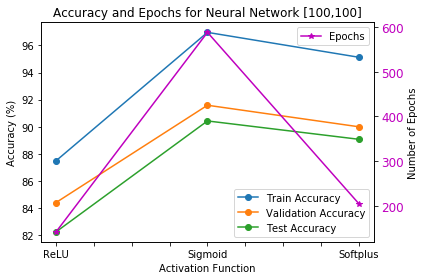

In [157]:
print("------------------Plotting Graphs for Part D - ReLU of 2 Hidden Layer ARCH ------------------")
x=[0,1,2]
data = [' ','ReLU', ' ' ,' ' ,' ','Sigmoid', ' ',' ',' ','Softplus']
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Accuracy and Epochs for Neural Network [100,100]")
ax.plot(x, train_accuracy, marker='o', label='Train Accuracy')
ax.plot(x, valid_accuracy, marker='o',label='Validation Accuracy')
ax.plot(x, test_accuracy, marker='o', label='Test Accuracy')
ax.set_xlabel("Activation Function")
ax.set_xticklabels(data)
ax.set_ylabel("Accuracy (%)")
ax.legend()
ax1=ax.twinx()
ax1.set_ylabel("Number of Epochs")
ax1.plot(x, epochs, marker='*', color='m',label='Epochs')
ax1.tick_params(axis='y', labelcolor='m', labelsize=12)
ax1.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig("plots/partd/comp_diff_act.png", dpi=1000, bbox_inches='tight')
plt.show()


### Part F - Binary Cross Entropy With ReLU activation

In [178]:
epochs=[]
train_accuracy = []
valid_accuracy = []
test_accuracy = []
train_time = []

In [179]:
print("----------------------------Running Part F-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with ReLU activation and Cross Entropy------------------")

----------------------------Running Part F-----------------------------------------------------
------------------Training a 100x100 hidden layer network with ReLU activation and Cross Entropy------------------


In [180]:
arch=[100, 100]
lr=0.1
theta = theta_init(n, r, arch, 'normal')
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'relu', 'adaptive', 'entropy')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc, 'relu'))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc, 'relu'))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc, 'relu'))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with ReLU are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with ReLU is = {}".format(epochs[-1]))
print("The training time with ReLU is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with ReLU is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with ReLU is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with ReLU is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 2 hidden layer with [100, 100] units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (101, 100)
theta between layer 2 and layer 3 is (101, 26)
Initial Cost on Val dataset for this epoch 1 = 17.901383893296945
learning rate for this epoch =  0.1
Error on this batch = 17.89721578625675
Error on this batch = 4.604033332206689
Cost on val dataset after 2 epochs is = 4.171266974682238
Initial Cost on Val dataset for this epoch 2 = 4.171266974682238
learning rate for this epoch =  0.08408964152537146
Error on this batch = 4.157265536554206
Error on this batch = 3.474939642069099
Cost on val dataset after 3 epochs is = 2.8478910470909926
Initial Cost on Val dataset for this epoch 3 = 2.8478910470909926
learning rate for this epoch =  0.07598356856515927
Error on this batch = 2.774500042844477
Error on this batch = 2.6790828682956356
Cost on val dataset after 4 epochs is = 2.2040228179

Cost on val dataset after 32 epochs is = 1.083082037159882
Initial Cost on Val dataset for this epoch 32 = 1.083082037159882
learning rate for this epoch =  0.04204482076268573
Error on this batch = 0.8217006095139037
Error on this batch = 1.1509390146976388
Cost on val dataset after 33 epochs is = 1.0795678766906542
Initial Cost on Val dataset for this epoch 33 = 1.0795678766906542
learning rate for this epoch =  0.04172261448611506
Error on this batch = 0.8181938630064265
Error on this batch = 1.1446990640640704
Cost on val dataset after 34 epochs is = 1.0761646018987852
Initial Cost on Val dataset for this epoch 34 = 1.0761646018987852
learning rate for this epoch =  0.041412387656655204
Error on this batch = 0.8143973712134508
Error on this batch = 1.1389130440668354
Cost on val dataset after 35 epochs is = 1.0730155920483009
Initial Cost on Val dataset for this epoch 35 = 1.0730155920483009
learning rate for this epoch =  0.04111336169005197
Error on this batch = 0.810668052379808

Cost on val dataset after 64 epochs is = 1.0301677233153075
Initial Cost on Val dataset for this epoch 64 = 1.0301677233153075
learning rate for this epoch =  0.035355339059327376
Error on this batch = 0.7525712346792088
Error on this batch = 1.0414964167249556
Cost on val dataset after 65 epochs is = 1.0298608329336356
Initial Cost on Val dataset for this epoch 65 = 1.0298608329336356
learning rate for this epoch =  0.03521856535823236
Error on this batch = 0.751912065722261
Error on this batch = 1.040432927302541
Cost on val dataset after 66 epochs is = 1.0297112432127649
Initial Cost on Val dataset for this epoch 66 = 1.0297112432127649
learning rate for this epoch =  0.035084396956386855
Error on this batch = 0.7513912564437039
Error on this batch = 1.0396461140236573
Cost on val dataset after 67 epochs is = 1.0295036157879063
Initial Cost on Val dataset for this epoch 67 = 1.0295036157879063
learning rate for this epoch =  0.034952745865855124
Error on this batch = 0.7506656190064

In [181]:
print("----------------------------Running Part F-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with Softplus activation and Cross Entropy------------------")

----------------------------Running Part F-----------------------------------------------------
------------------Training a 100x100 hidden layer network with Softplus activation and Cross Entropy------------------


In [182]:
arch=[100, 100]
lr=0.1
theta = theta_init(n, r, arch, 'normal')
print("Training the network with {} hidden layer with {} units".format(len(arch), arch))
print("The parameters of the layers are of the shape:")

for j in range(len(theta)):
    print("theta between layer {} and layer {} is {}".format(j, j+1,theta[j].shape))
    
start = time.time()
epoch, theta = training(mini_batch, X_valid, valid_class_enc, theta, lr, 'softplus', 'adaptive', 'entropy')

epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc, 'softplus'))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc, 'softplus'))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc, 'softplus'))

print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer = {} with softplus are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs with softplus is = {}".format(epochs[-1]))
print("The training time with softplus is = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy with softplus is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy with softplus is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy with softplus is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

Training the network with 2 hidden layer with [100, 100] units
The parameters of the layers are of the shape:
theta between layer 0 and layer 1 is (785, 100)
theta between layer 1 and layer 2 is (101, 100)
theta between layer 2 and layer 3 is (101, 26)
Initial Cost on Val dataset for this epoch 1 = 19.81503930292858
learning rate for this epoch =  0.1
Error on this batch = 19.794280492670666
Error on this batch = 4.175317200313914
Cost on val dataset after 2 epochs is = 4.024354564890312
Initial Cost on Val dataset for this epoch 2 = 4.024354564890312
learning rate for this epoch =  0.08408964152537146
Error on this batch = 4.051570739139761
Error on this batch = 3.4029525993912
Cost on val dataset after 3 epochs is = 2.9019077904745707
Initial Cost on Val dataset for this epoch 3 = 2.9019077904745707
learning rate for this epoch =  0.07598356856515927
Error on this batch = 2.939627005348293
Error on this batch = 2.645088093797996
Cost on val dataset after 4 epochs is = 2.1807688193833

Cost on val dataset after 32 epochs is = 0.8619982543747718
Initial Cost on Val dataset for this epoch 32 = 0.8619982543747718
learning rate for this epoch =  0.04204482076268573
Error on this batch = 0.564440134197126
Error on this batch = 0.9155812301188323
Cost on val dataset after 33 epochs is = 0.8538708642457267
Initial Cost on Val dataset for this epoch 33 = 0.8538708642457267
learning rate for this epoch =  0.04172261448611506
Error on this batch = 0.5536120816443589
Error on this batch = 0.9042614203676581
Cost on val dataset after 34 epochs is = 0.8460647459155728
Initial Cost on Val dataset for this epoch 34 = 0.8460647459155728
learning rate for this epoch =  0.041412387656655204
Error on this batch = 0.5432151008384287
Error on this batch = 0.8932964255127908
Cost on val dataset after 35 epochs is = 0.8385644798365265
Initial Cost on Val dataset for this epoch 35 = 0.8385644798365265
learning rate for this epoch =  0.04111336169005197
Error on this batch = 0.53322244329012

Error on this batch = 0.6575779437753928
Cost on val dataset after 64 epochs is = 0.7095241290087071
Initial Cost on Val dataset for this epoch 64 = 0.7095241290087071
learning rate for this epoch =  0.035355339059327376
Error on this batch = 0.35133024348788433
Error on this batch = 0.651120765194832
Cost on val dataset after 65 epochs is = 0.7070568398602558
Initial Cost on Val dataset for this epoch 65 = 0.7070568398602558
learning rate for this epoch =  0.03521856535823236
Error on this batch = 0.3473302377733606
Error on this batch = 0.6447475526927045
Cost on val dataset after 66 epochs is = 0.7046750682018554
Initial Cost on Val dataset for this epoch 66 = 0.7046750682018554
learning rate for this epoch =  0.035084396956386855
Error on this batch = 0.34341977731816914
Error on this batch = 0.6384573677114791
Cost on val dataset after 67 epochs is = 0.7023760920229639
Initial Cost on Val dataset for this epoch 67 = 0.7023760920229639
learning rate for this epoch =  0.034952745865

Error on this batch = 0.4873879187714366
Cost on val dataset after 96 epochs is = 0.6636587560904479
Initial Cost on Val dataset for this epoch 96 = 0.6636587560904479
learning rate for this epoch =  0.03194715521231362
Error on this batch = 0.25346209169954426
Error on this batch = 0.48305737681519106
Cost on val dataset after 97 epochs is = 0.6630895618182764
Initial Cost on Val dataset for this epoch 97 = 0.6630895618182764
learning rate for this epoch =  0.031864496938342195
Error on this batch = 0.2510089913201687
Error on this batch = 0.47876943138302963
Cost on val dataset after 98 epochs is = 0.6625614450315347
Initial Cost on Val dataset for this epoch 98 = 0.6625614450315347
learning rate for this epoch =  0.031782897044671854
Error on this batch = 0.24857726090304874
Error on this batch = 0.4745226380764392
Cost on val dataset after 99 epochs is = 0.6620736495047799
Initial Cost on Val dataset for this epoch 99 = 0.6620736495047799
learning rate for this epoch =  0.031702331

------------------Plotting Graphs for Part F - ReLU with Cross Entropy ------------------


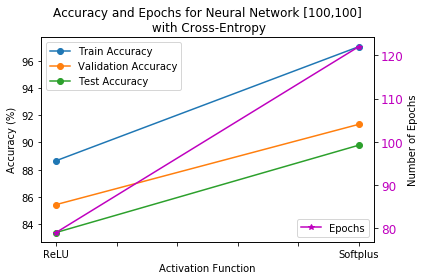

In [189]:
print("------------------Plotting Graphs for Part F - ReLU with Cross Entropy ------------------")
x=[0,1]
data = [' ','ReLU', ' ' ,' ' ,' ',' ','Softplus']
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Accuracy and Epochs for Neural Network [100,100]\n with Cross-Entropy")
ax.plot(x, train_accuracy, marker='o', label='Train Accuracy')
ax.plot(x, valid_accuracy, marker='o',label='Validation Accuracy')
ax.plot(x, test_accuracy, marker='o', label='Test Accuracy')
ax.set_xlabel("Activation Function")
ax.set_xticklabels(data)
ax.set_ylabel("Accuracy (%)")
ax.legend()
ax1=ax.twinx()
ax1.set_ylabel("Number of Epochs")
ax1.plot(x, epochs, marker='*', color='m',label='Epochs')
ax1.tick_params(axis='y', labelcolor='m', labelsize=12)
plt.legend(loc=4)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig("plots/partf/comp_diff_act.png", dpi=1000, bbox_inches='tight')
plt.show()


## Part E - MLP Classifier using SKLEARN

In [238]:
print("----------------------------Running Part E-----------------------------------------------------")
print("------------------Training a 100x100 hidden layer network with MLP Classifier------------------")

----------------------------Running Part E-----------------------------------------------------
------------------Training a 100x100 hidden layer network with MLP Classifier------------------


In [98]:
from sklearn.neural_network import MLPClassifier as mlp_classifier
PATH = os.getcwd()
os.chdir('Alphabets/')
X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)
train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

os.chdir('../')

X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features
train_class_enc = pd.get_dummies(train_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()

In [123]:
epochs = []
train_accuracy = []
test_accuracy = []
train_time = []


In [124]:
clf=[]
#Classifier - logistic with constant LR
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='logistic', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     tol=1e-5, verbose=False))
#Classifier - logistic with early_stopping =False
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='logistic', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     early_stopping=False, tol=1e-5, verbose=False))
#Classifier - logistic with invscaling with lr0=0.3 and p=5
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='logistic', solver='sgd', 
                     batch_size=100, learning_rate_init=0.3, learning_rate='invscaling', max_iter=400,
                     power_t=(1/5), tol=1e-5, verbose=False))
#Classifier - logistic with invscaling with pow(1/3)
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='logistic', solver='sgd', 
                     batch_size=100, learning_rate_init=0.3, learning_rate='invscaling', max_iter=400,
                     power_t=(1/4), tol=1e-5, verbose=False))


#Classifier ReLU with constant LR (1e-5) lr=0.03
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.03, learning_rate='constant', max_iter=400,
                     tol=1e-5, verbose=False))
#Classifier ReLU with constant LR (1e-5) lr=0.1
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     tol=1e-5, verbose=False))
#Classifier ReLU with constant LR (1e-5) with early stopping
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='constant', max_iter=400,
                     early_stopping=False, tol=1e-5, verbose=False))

#Classifier ReLU with constant LR (1e-6) with invscaling sqrt
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='invscaling', max_iter=400,
                     power_t=(1/2), tol=1e-5, verbose=False))
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='invscaling', max_iter=400,
                     power_t=(1/3), tol=1e-5, verbose=False))
#Classifier ReLU with constant LR (1e-6) with invscaling pow(1/3)
clf.append(mlp_classifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', 
                     batch_size=100, learning_rate_init=0.1, learning_rate='invscaling', max_iter=400,
                     power_t=(1/4), tol=1e-5, verbose=False))

In [125]:
for i in range(len(clf)):
    print("--------Training the classifier with following params--------------")
    print("-------------------------------------------------------------------")
    print(clf[i])
    print("-------------------------------------------------------------------")
    start =time.time()
    clf[i].fit(X_train, train_class_enc)
    end = time.time()
    epochs.append(clf[i].n_iter_)
    train_accuracy.append(clf[i].score(X_train, train_class_enc)*100)
    test_accuracy.append(clf[i].score(X_test, test_actual_class_enc)*100)
    train_time.append(end-start)
    print("The training Accuracy achieved is = {:2.3f}".format(train_accuracy[-1]))
    print("The test Accuracy achieved is = {:2.3f}".format(test_accuracy[-1]))    
    print("The number of epochs is = {}".format(epochs[-1]))    
    print("The training time achieved is = {:2.3f}".format(train_time[-1]))    

--------Training the classifier with following params--------------
-------------------------------------------------------------------
MLPClassifier(activation='logistic', alpha=0.0001, batch_size=100, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=400, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=1e-05,
              validation_fraction=0.1, verbose=True, warm_start=False)
-------------------------------------------------------------------
Iteration 1, loss = 4.40204009
Iteration 2, loss = 3.66074777
Iteration 3, loss = 2.62139016
Iteration 4, loss = 1.97130534
Iteration 5, loss = 1.48572083
Iteration 6, loss = 1.21746981
Iteration 7, loss = 1.04363075
Iteration 8, loss = 0.92358638
Iteration 9, loss = 0.82895469
Itera

Iteration 231, loss = 0.00818206
Iteration 232, loss = 0.00816669
Iteration 233, loss = 0.00815445
Iteration 234, loss = 0.00814171
Iteration 235, loss = 0.00812549
Iteration 236, loss = 0.00811395
Iteration 237, loss = 0.00810097
Iteration 238, loss = 0.00809088
Iteration 239, loss = 0.00807933
Iteration 240, loss = 0.00806483
Iteration 241, loss = 0.00805517
Iteration 242, loss = 0.00804530
Iteration 243, loss = 0.00803136
Iteration 244, loss = 0.00802000
Iteration 245, loss = 0.00800937
Iteration 246, loss = 0.00799755
Iteration 247, loss = 0.00798497
Iteration 248, loss = 0.00797602
Iteration 249, loss = 0.00796509
Iteration 250, loss = 0.00795512
Iteration 251, loss = 0.00794356
Iteration 252, loss = 0.00793086
Iteration 253, loss = 0.00792437
Iteration 254, loss = 0.00791360
Iteration 255, loss = 0.00790178
Iteration 256, loss = 0.00789237
Iteration 257, loss = 0.00788448
Iteration 258, loss = 0.00787165
Iteration 259, loss = 0.00786263
Iteration 260, loss = 0.00785138
Iteration 

Iteration 24, loss = 1.96731984
Iteration 25, loss = 1.87869472
Iteration 26, loss = 1.79595583
Iteration 27, loss = 1.72311480
Iteration 28, loss = 1.65537157
Iteration 29, loss = 1.59668851
Iteration 30, loss = 1.53917002
Iteration 31, loss = 1.48533925
Iteration 32, loss = 1.43538380
Iteration 33, loss = 1.38690275
Iteration 34, loss = 1.34124156
Iteration 35, loss = 1.29574277
Iteration 36, loss = 1.25359031
Iteration 37, loss = 1.21260901
Iteration 38, loss = 1.17481083
Iteration 39, loss = 1.13796467
Iteration 40, loss = 1.10518988
Iteration 41, loss = 1.07163165
Iteration 42, loss = 1.04040277
Iteration 43, loss = 1.00928791
Iteration 44, loss = 0.98259498
Iteration 45, loss = 0.95702545
Iteration 46, loss = 0.93129600
Iteration 47, loss = 0.90744259
Iteration 48, loss = 0.88489825
Iteration 49, loss = 0.86163559
Iteration 50, loss = 0.84010861
Iteration 51, loss = 0.82035608
Iteration 52, loss = 0.80119383
Iteration 53, loss = 0.78230972
Iteration 54, loss = 0.76437147
Iteratio

Iteration 275, loss = 0.07055748
Iteration 276, loss = 0.07021660
Iteration 277, loss = 0.06981383
Iteration 278, loss = 0.06944030
Iteration 279, loss = 0.06910058
Iteration 280, loss = 0.06874581
Iteration 281, loss = 0.06836807
Iteration 282, loss = 0.06819712
Iteration 283, loss = 0.06769244
Iteration 284, loss = 0.06745178
Iteration 285, loss = 0.06713470
Iteration 286, loss = 0.06673338
Iteration 287, loss = 0.06650850
Iteration 288, loss = 0.06613529
Iteration 289, loss = 0.06580907
Iteration 290, loss = 0.06552046
Iteration 291, loss = 0.06518692
Iteration 292, loss = 0.06489363
Iteration 293, loss = 0.06458532
Iteration 294, loss = 0.06433693
Iteration 295, loss = 0.06392932
Iteration 296, loss = 0.06369468
Iteration 297, loss = 0.06342810
Iteration 298, loss = 0.06310827
Iteration 299, loss = 0.06288065
Iteration 300, loss = 0.06253422
Iteration 301, loss = 0.06231723
Iteration 302, loss = 0.06201085
Iteration 303, loss = 0.06171358
Iteration 304, loss = 0.06139961
Iteration 

Iteration 101, loss = 0.68473413
Iteration 102, loss = 0.67802450
Iteration 103, loss = 0.67195478
Iteration 104, loss = 0.66561303
Iteration 105, loss = 0.65989320
Iteration 106, loss = 0.65461498
Iteration 107, loss = 0.64822412
Iteration 108, loss = 0.64220850
Iteration 109, loss = 0.63660359
Iteration 110, loss = 0.63122280
Iteration 111, loss = 0.62552928
Iteration 112, loss = 0.62031232
Iteration 113, loss = 0.61445731
Iteration 114, loss = 0.60911162
Iteration 115, loss = 0.60465334
Iteration 116, loss = 0.59933084
Iteration 117, loss = 0.59382760
Iteration 118, loss = 0.58915062
Iteration 119, loss = 0.58460169
Iteration 120, loss = 0.57980956
Iteration 121, loss = 0.57469338
Iteration 122, loss = 0.56973948
Iteration 123, loss = 0.56566116
Iteration 124, loss = 0.56092946
Iteration 125, loss = 0.55613936
Iteration 126, loss = 0.55142383
Iteration 127, loss = 0.54755226
Iteration 128, loss = 0.54314335
Iteration 129, loss = 0.53878096
Iteration 130, loss = 0.53458791
Iteration 

Iteration 350, loss = 0.16151394
Iteration 351, loss = 0.16078277
Iteration 352, loss = 0.16020924
Iteration 353, loss = 0.15941608
Iteration 354, loss = 0.15892590
Iteration 355, loss = 0.15828927
Iteration 356, loss = 0.15772549
Iteration 357, loss = 0.15699518
Iteration 358, loss = 0.15629608
Iteration 359, loss = 0.15576000
Iteration 360, loss = 0.15509468
Iteration 361, loss = 0.15463720
Iteration 362, loss = 0.15393751
Iteration 363, loss = 0.15324088
Iteration 364, loss = 0.15275656
Iteration 365, loss = 0.15217961
Iteration 366, loss = 0.15172107
Iteration 367, loss = 0.15089837
Iteration 368, loss = 0.15059529
Iteration 369, loss = 0.14990252
Iteration 370, loss = 0.14923178
Iteration 371, loss = 0.14867130
Iteration 372, loss = 0.14816523
Iteration 373, loss = 0.14754876
Iteration 374, loss = 0.14700140
Iteration 375, loss = 0.14642965
Iteration 376, loss = 0.14601514
Iteration 377, loss = 0.14524276
Iteration 378, loss = 0.14477154
Iteration 379, loss = 0.14436931
Iteration 

Iteration 7, loss = 0.45466208
Iteration 8, loss = 0.41740540
Iteration 9, loss = 0.40251739
Iteration 10, loss = 0.38387278
Iteration 11, loss = 0.38546111
Iteration 12, loss = 0.31049517
Iteration 13, loss = 0.29283614
Iteration 14, loss = 0.29064743
Iteration 15, loss = 0.28061811
Iteration 16, loss = 0.26203566
Iteration 17, loss = 0.23036564
Iteration 18, loss = 0.25744236
Iteration 19, loss = 0.28180248
Iteration 20, loss = 0.26243069
Iteration 21, loss = 0.23746253
Iteration 22, loss = 0.22963996
Iteration 23, loss = 0.21726602
Iteration 24, loss = 0.29524830
Iteration 25, loss = 0.21364457
Iteration 26, loss = 0.23123348
Iteration 27, loss = 0.22795417
Iteration 28, loss = 0.26122991
Iteration 29, loss = 0.23128931
Iteration 30, loss = 0.23307178
Iteration 31, loss = 0.22865244
Iteration 32, loss = 0.26366610
Iteration 33, loss = 0.22509109
Iteration 34, loss = 0.22665693
Iteration 35, loss = 0.20683230
Iteration 36, loss = 0.21010729
Iteration 37, loss = 0.23322607
Iteration 3

Iteration 109, loss = 0.92095441
Iteration 110, loss = 0.92045281
Iteration 111, loss = 0.91997026
Iteration 112, loss = 0.91946343
Iteration 113, loss = 0.91898389
Iteration 114, loss = 0.91854619
Iteration 115, loss = 0.91803954
Iteration 116, loss = 0.91754126
Iteration 117, loss = 0.91708428
Iteration 118, loss = 0.91662288
Iteration 119, loss = 0.91617878
Iteration 120, loss = 0.91568364
Iteration 121, loss = 0.91523951
Iteration 122, loss = 0.91481068
Iteration 123, loss = 0.91431557
Iteration 124, loss = 0.91385689
Iteration 125, loss = 0.91343110
Iteration 126, loss = 0.91296676
Iteration 127, loss = 0.91258223
Iteration 128, loss = 0.91208481
Iteration 129, loss = 0.91164543
Iteration 130, loss = 0.91127515
Iteration 131, loss = 0.91086186
Iteration 132, loss = 0.91038538
Iteration 133, loss = 0.90996572
Iteration 134, loss = 0.90954440
Iteration 135, loss = 0.90909752
Iteration 136, loss = 0.90871332
Iteration 137, loss = 0.90829956
Iteration 138, loss = 0.90791209
Iteration 

Iteration 358, loss = 0.84824036
Iteration 359, loss = 0.84803610
Iteration 360, loss = 0.84786221
Iteration 361, loss = 0.84766666
Iteration 362, loss = 0.84746268
Iteration 363, loss = 0.84727543
Iteration 364, loss = 0.84706110
Iteration 365, loss = 0.84686935
Iteration 366, loss = 0.84667067
Iteration 367, loss = 0.84648897
Iteration 368, loss = 0.84633199
Iteration 369, loss = 0.84610225
Iteration 370, loss = 0.84590900
Iteration 371, loss = 0.84574617
Iteration 372, loss = 0.84552312
Iteration 373, loss = 0.84533882
Iteration 374, loss = 0.84516721
Iteration 375, loss = 0.84497333
Iteration 376, loss = 0.84477417
Iteration 377, loss = 0.84458420
Iteration 378, loss = 0.84443227
Iteration 379, loss = 0.84421148
Iteration 380, loss = 0.84403171
Iteration 381, loss = 0.84380755
Iteration 382, loss = 0.84365738
Iteration 383, loss = 0.84346041
Iteration 384, loss = 0.84325605
Iteration 385, loss = 0.84308005
Iteration 386, loss = 0.84289855
Iteration 387, loss = 0.84270491
Iteration 

Iteration 183, loss = 0.22378002
Iteration 184, loss = 0.22308853
Iteration 185, loss = 0.22226440
Iteration 186, loss = 0.22129813
Iteration 187, loss = 0.22072569
Iteration 188, loss = 0.21971548
Iteration 189, loss = 0.21924308
Iteration 190, loss = 0.21852067
Iteration 191, loss = 0.21750360
Iteration 192, loss = 0.21688271
Iteration 193, loss = 0.21618128
Iteration 194, loss = 0.21551231
Iteration 195, loss = 0.21462492
Iteration 196, loss = 0.21392063
Iteration 197, loss = 0.21323670
Iteration 198, loss = 0.21264538
Iteration 199, loss = 0.21171549
Iteration 200, loss = 0.21116058
Iteration 201, loss = 0.21031539
Iteration 202, loss = 0.20991482
Iteration 203, loss = 0.20894214
Iteration 204, loss = 0.20833130
Iteration 205, loss = 0.20765074
Iteration 206, loss = 0.20685114
Iteration 207, loss = 0.20632746
Iteration 208, loss = 0.20553188
Iteration 209, loss = 0.20500502
Iteration 210, loss = 0.20418192
Iteration 211, loss = 0.20355915
Iteration 212, loss = 0.20295277
Iteration 

Iteration 6, loss = 0.58025195
Iteration 7, loss = 0.55987122
Iteration 8, loss = 0.53958283
Iteration 9, loss = 0.52299793
Iteration 10, loss = 0.50883853
Iteration 11, loss = 0.49523129
Iteration 12, loss = 0.48299034
Iteration 13, loss = 0.47009574
Iteration 14, loss = 0.45982906
Iteration 15, loss = 0.45124358
Iteration 16, loss = 0.44011492
Iteration 17, loss = 0.43085941
Iteration 18, loss = 0.42184192
Iteration 19, loss = 0.41269597
Iteration 20, loss = 0.40568441
Iteration 21, loss = 0.39768676
Iteration 22, loss = 0.39032091
Iteration 23, loss = 0.38272313
Iteration 24, loss = 0.37585606
Iteration 25, loss = 0.37127166
Iteration 26, loss = 0.36485406
Iteration 27, loss = 0.35676028
Iteration 28, loss = 0.35136442
Iteration 29, loss = 0.34566282
Iteration 30, loss = 0.33892398
Iteration 31, loss = 0.33487128
Iteration 32, loss = 0.33031968
Iteration 33, loss = 0.32420922
Iteration 34, loss = 0.31845482
Iteration 35, loss = 0.31468834
Iteration 36, loss = 0.31012624
Iteration 37

Iteration 258, loss = 0.03440347
Iteration 259, loss = 0.03418925
Iteration 260, loss = 0.03395377
Iteration 261, loss = 0.03377979
Iteration 262, loss = 0.03339570
Iteration 263, loss = 0.03330592
Iteration 264, loss = 0.03304871
Iteration 265, loss = 0.03283415
Iteration 266, loss = 0.03256884
Iteration 267, loss = 0.03239052
Iteration 268, loss = 0.03220928
Iteration 269, loss = 0.03195420
Iteration 270, loss = 0.03170700
Iteration 271, loss = 0.03154922
Iteration 272, loss = 0.03138918
Iteration 273, loss = 0.03111388
Iteration 274, loss = 0.03095575
Iteration 275, loss = 0.03071109
Iteration 276, loss = 0.03052132
Iteration 277, loss = 0.03027156
Iteration 278, loss = 0.03015775
Iteration 279, loss = 0.02993633
Iteration 280, loss = 0.02971359
Iteration 281, loss = 0.02963429
Iteration 282, loss = 0.02938193
Iteration 283, loss = 0.02918376
Iteration 284, loss = 0.02903303
Iteration 285, loss = 0.02876871
Iteration 286, loss = 0.02863484
Iteration 287, loss = 0.02848699
Iteration 

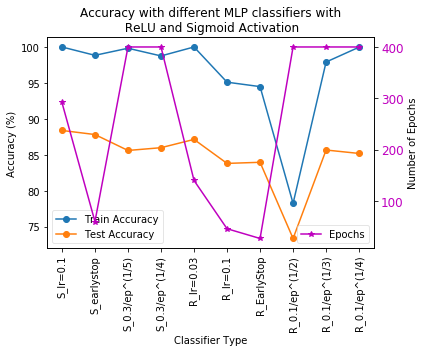

In [149]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
ax.set_title("Accuracy with different MLP classifiers with\n ReLU and Sigmoid Activation")
data=['S_lr=0.1', 'S_earlystop','S_0.3/ep^(1/5)','S_0.3/ep^(1/4)','R_lr=0.03', 'R_lr=0.1', 'R_EarlyStop', 'R_0.1/ep^(1/2)', 'R_0.1/ep^(1/3)', 'R_0.1/ep^(1/4)']
ax.plot(x, train_accuracy, marker='o', label='Train Accuracy')
ax.plot(x, test_accuracy, marker='o', label='Test Accuracy')
ax.set_xlabel("Classifier Type")
ax.set_xticklabels(data, rotation=90)
ax.set_ylabel("Accuracy (%)")
ax.legend(framealpha=0.5)
ax.set_xticks(range(0,len(clf)))
ax1=ax.twinx()
ax1.set_ylabel("Number of Epochs")
ax1.plot(x, epochs, marker='*', color='m',label='Epochs')
ax1.tick_params(axis='y', labelcolor='m', labelsize=12)
plt.legend(loc=4,framealpha=0.5)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig("plots/parte/accuracy_final.png", dpi=1000, bbox_inches='tight')
plt.show()